In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Normalization

In [2]:
survey_normalizing_dict = {
    'big picture / lack of synthesis': 'big picture',
    'lack of synethesis': 'big picture',
    'synthesis of results': 'big picture',
    'lack of synthesis': 'big picture',
    'higher-level / holistic / unified understanding': 'big picture',
    
    'unified theory': 'unification',
    'lack of unification': 'unification',
    'high-level abstractions': 'unification',
    
    'causaility': 'causality',
    'internal causes': 'causality',
    'internal causes rather than output behaviour': 'causality',

    'human evaluation / user studies': 'human evaluation',
    'real world examples': 'realistic evaluation',
    'real world data': 'realistic evaluation',
    'point of reference': 'ground truth',
    
    'real world usecase': 'utility',
    
    'lack of community / conferences': 'lack of community',
    
    'modeling improvement': 'modeling improvements',
    'model improvements': 'modeling improvements',
    
    'scaling up': 'scaling',
    
    'tools': 'tooling',
    'high quality tools': 'tooling',
    
    'more interdisciplinary research': 'interdisciplinarity',
    'collaborations with domain experts': 'interdisciplinarity',
    
    'theoretical description': 'theory',
    
    'weight-based predictions without running': 'predicting model behaviour',
    
    'a priori': 'interpretability by design',
    
    'pre-training': 'training dynamics',
    'trajectories': 'training dynamics',
    
    'educating general public': 'better stakeholder communication',
    'who is the target audience?': 'better stakeholder communication',

    'data efficiency': 'efficiency',
    'efficiency (cost / compute / etc.)': 'efficiency',
    'more efficient analysis approaches': 'efficiency',
    
    'clear hypotheses needed': 'falsifiable hypotheses',
    
    'less speculation': 'more rigor',
    
    'automating interpretability': 'automation',
}

In [3]:
papers_normalizing_dict = {
    'novel framework': 'novel method',
    'world model': 'world models',
    'explanation': 'explanations',
    'neuro analysis': 'neuron analysis',
    'representational analysis': 'representation analysis',
    'novel architecture': 'novel model',
    'extract rules': 'rule extraction',
    'hate speech': 'abusive language',
    'toxicity': 'abusive language',
    'offensive language': 'abusive language',
    'explainabaility': 'explainability',
    'evaluation analysis': 'methods evaluation',
    'novel research problem': 'novel task',
    'synthetic data generation': 'synthetic data',
    'visual language models': 'vision-language models',
    'stereotype detection': 'stereotypes',
    'stereotypical bias': 'stereotypes',
    'sterotype detection': 'stereotypes',
    'sterotypes': 'stereotypes',
    'retrieval. recommender systems': 'retrieval',
    'saliency maps': 'saliency',
    'saliency scores': 'saliency',
    'novel approach': 'novel method',
    'novel benchmarks': 'novel benchmark',
    'novel methods': 'novel method',
    'novel metrics': 'novel metric',
    'novel system': 'novel model',
    'intersectional biases': 'intersectional bias',
    'multi-modal models': 'multi-modal',
    'interpretabiliy': 'interpretability',
    'multilungual': 'multilingual',
    'multimodal models': 'multimodal',
    'attribution method': 'attribution',
    'attribution methods': 'attribution',
    'applications': 'application',
    'in-conext learning': 'in-context learning',
    'in-contex learning': 'in-context learning',
    'instruction following': 'instruction-following',
    'low-resource': 'low resource',
    'attention anaysis': 'attention analysis',
    'dialog': 'dialogue',
    'dialog systems': 'dialogue systems',
    'cross-lingual': 'multilingual',
    'intervention': 'interventions',
    'gender bias': 'gender',
}

In [4]:
papers_additions = [
    ('explanations', 'explainability'),
]

In [5]:
def normalize(theme, normalizing_dict):
    if theme in normalizing_dict:
        return normalizing_dict[theme]
    return theme

In [6]:
def normalize_col(row, column, normalizing_dict, additions=[]):
    ts = ''
    if type(row[column]) == str:
        ts = row[column]
    norm = [normalize(t.strip().lower(), normalizing_dict) for t in ts.split(',')]
    additional = []
    for key,val in additions:
        if key in norm:
            additional.append(val)
    return ','.join(norm + additional)

## Reading files

In [7]:
def get_df(filename, normalizing_dict, length=None, additions=[], filter_for_themes=True):
    df = pd.read_csv(filename, sep='\t' if '.tsv' in filename else ',')
    df = df.rename({'marius_topic': 'marius_themes', 'vagrant_topic': 'vagrant_themes',
                    'marius_notes': 'marius_themes', 'vagrant_notes': 'vagrant_themes'}, axis=1)
    if 'interpretability_prediction' in df.columns:
        df['interpretability_prediction'] = df['interpretability_prediction'].fillna(False)
    if filter_for_themes:
        if 'papers_processed_unique' in filename:
            df = df[df.marius_themes.notna()]
        else:
            df = df[df.marius_themes.notna() | df.vagrant_themes.notna()]
    assert 'vagrant_themes' in df and 'marius_themes' in df
    df['vagrant_themes'] = df.apply(normalize_col, axis=1, args=('vagrant_themes', normalizing_dict, additions))
    df['marius_themes'] = df.apply(normalize_col, axis=1, args=('marius_themes', normalizing_dict, additions))
    if length:
        assert len(df) == length
    return df

In [8]:
whats_missing_df = get_df('whats_missing.tsv', survey_normalizing_dict, 42)

In [9]:
survey_interp_df = get_df('papers_processed_unique.tsv', survey_normalizing_dict, 29)

In [10]:
top50_interp_df = get_df('top_50_interp_papers.tsv', papers_normalizing_dict, 50, additions=papers_additions)

In [11]:
top50_other_df = get_df('all_top_50_cited_papers.tsv', papers_normalizing_dict, 50, additions=papers_additions)

In [12]:
citations_to_top50_interp_df = get_df('top_50_interp_papers_citations.tsv', papers_normalizing_dict, additions=papers_additions)

In [13]:
additional_thoughts_df = get_df('additional_thoughts.tsv', survey_normalizing_dict)

In [14]:
why_not_important_df = get_df('why_not_important.tsv', survey_normalizing_dict)

In [15]:
citations_df = get_df('top_50_interp_papers_citations.tsv', papers_normalizing_dict, additions=papers_additions, filter_for_themes=False)

## Paper influences

In [16]:
paper_influences = {}
grouped = citations_df.groupby(['cited_paper_title', 'influential_citation', 'interpretability_prediction']).size().reset_index().groupby('cited_paper_title')
for name in grouped.groups:
    group = grouped.get_group(name)
    assert group.iloc[0]['influential_citation'] == False and group.iloc[0]['interpretability_prediction'] == False
    assert group.iloc[1]['influential_citation'] == False and group.iloc[1]['interpretability_prediction'] == True
    assert group.iloc[2]['influential_citation'] == True and group.iloc[2]['interpretability_prediction'] == False
    assert group.iloc[3]['influential_citation'] == True and group.iloc[3]['interpretability_prediction'] == True
    a, b, c, d = (group[0].iloc[0], group[0].iloc[1], group[0].iloc[2], group[0].iloc[3])
    # 0: influential non-IA / not influential non-IA
    # 1: influential IA / not influential IA
    paper_influences[group.iloc[0]['cited_paper_title']] = (c/a, d/b)
#     print()

In [17]:
plot_df = pd.DataFrame(paper_influences).transpose().rename({0: 'non-IA', 1: 'IA'}, axis=1)

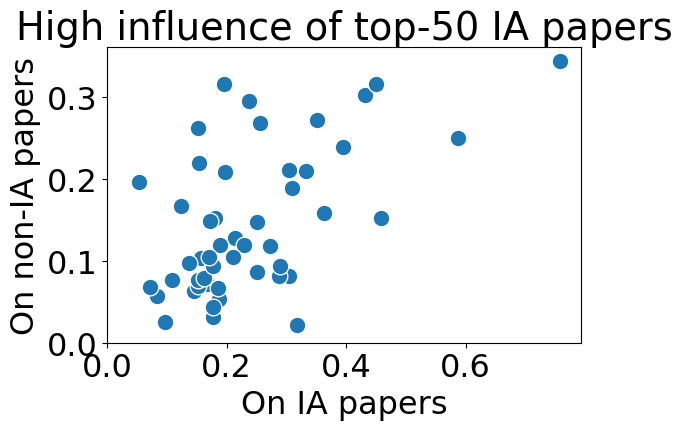

In [18]:
sns.scatterplot(plot_df, x='IA', y='non-IA')
plt.ylabel('On non-IA papers')
plt.xlabel('On IA papers')
plt.title('High influence of top-50 IA papers')
plt.tight_layout()
plt.xlim([0,None])
plt.ylim([0,None])
plt.show()

## Get all themes

In [19]:
def get_all_themes(df, normalizing_dict):
    vagrant_themes = []
    for ts in list(df['vagrant_themes']):
        if type(ts) != float:
            vagrant_themes += [normalize(t.strip().lower(), normalizing_dict) for t in ts.split(',')]

    marius_themes = []
    for ts in list(df['marius_themes']):
        if type(ts) != float:
            marius_themes += [normalize(t.strip().lower(), normalizing_dict) for t in ts.split(',')]

    return sorted(list(set(vagrant_themes).union(set(marius_themes)) - set([''])))

In [20]:
get_all_themes(survey_interp_df, papers_normalizing_dict)

['activation analysis',
 'architecture',
 'attention analysis',
 'attribution',
 'causal mediation analysis',
 'causality',
 'computational model',
 'concepts',
 'counterfactuals',
 'emergent behaviour',
 'explainability',
 'explanations',
 'factuality',
 'faithfulness',
 'ffn analysis',
 'games',
 'gender',
 'grokking',
 'hallucination',
 'in-context learning',
 'influence functions',
 'information flow',
 'interdisciplinarity',
 'interventions',
 'key-value memories',
 'language modelling',
 'limitations',
 'linguistics',
 'mechanistic interpretability',
 'memorization',
 'mlp analysis',
 'model editing',
 'multilingual',
 'neuron analysis',
 'new metaphor',
 'novel guidelines',
 'novel metaphor',
 'novel method',
 'patching',
 'pathological behaviour',
 'probing',
 'representation analysis',
 'representation space geometry',
 'residual stream',
 'reverse engineering',
 'robustness',
 'rule extraction',
 'scaling laws',
 'steering',
 'superposition',
 'survey',
 'toy models',
 'train

In [21]:
get_all_themes(top50_interp_df, papers_normalizing_dict)

['active learning',
 'adversarial evaluation',
 'analysis',
 'artifacts',
 'attention analysis',
 'attribution analysis',
 'backdoor attacks',
 'bias detection',
 'bias evaluation',
 'calibration',
 'causality',
 'classification',
 'code',
 'commonsense knowledge',
 'compositional generalization',
 'concepts',
 'confidence scores',
 'contextualized representations',
 'counterfactuals',
 'cross-lingual transfer',
 'data analysis',
 'data maps',
 'demonstration selection',
 'demonstrations',
 'diagnostics',
 'dimensionality',
 'disentangled representations',
 'distillation',
 'distributional hypothesis',
 'effectiveness',
 'evaluation',
 'evidence',
 'explainability',
 'explanations',
 'factual knowledge',
 'faithfulness',
 'ffn analysis',
 'fine-tuning',
 'formal languages',
 'free-text rationales',
 'generalization',
 'generation',
 'harms',
 'human evaluation',
 'humans',
 'in-context learning',
 'influence functions',
 'information flow',
 'information theory',
 'interpretability',
 

In [22]:
get_all_themes(top50_other_df, papers_normalizing_dict)

['acceptability',
 'adaptation',
 'adversarial evaluation',
 'adversarial robustness',
 'alignment',
 'analysis',
 'application',
 'architecture',
 'attention',
 'attention analysis',
 'behavioural testing',
 'bias detection',
 'bias mitigation',
 'classification',
 'code',
 'commonsense',
 'contrastive learning',
 'coreference',
 'critique',
 'cross-lingual transfer',
 'data augmentation',
 'demonstrations',
 'denoising',
 'dialogue',
 'dialogue agents',
 'efficiency',
 'embeddings',
 'environment',
 'ethics',
 'evaluation',
 'explainability',
 'explanations',
 'factual knowledge',
 'few-shot',
 'fine-tuning',
 'fusion',
 'generalization',
 'generation',
 'harms',
 'heuristics',
 'image captioning',
 'in-context learning',
 'instruction-following',
 'instruction-tuning',
 'interpretability',
 'knowledge bases',
 'knowledge graphs',
 'linguistics',
 'long context',
 'meaning',
 'mt',
 'multi-task learning',
 'multilingual',
 'multimodal',
 'ner',
 'nli',
 'nlu',
 'novel dataset',
 'nov

In [23]:
get_all_themes(citations_to_top50_interp_df, papers_normalizing_dict)

['abusive language',
 'activation function analysis',
 'active learning',
 'adapters',
 'adversarial evaluation',
 'adversarial robustness',
 'adversarial training',
 'affective bias',
 'agents',
 'aggregation',
 'agi',
 'ai feedback',
 'alignment',
 'analysis',
 'application',
 'application screening',
 'architecture',
 'artifacts',
 'attention',
 'attention analysis',
 'attribution',
 'attribution analysis',
 'audio',
 'audio embeddings',
 'autocompletion',
 'automotive',
 'backdoor attacks',
 'bayesian',
 'benchmarking',
 'bertscore',
 'bias',
 'bias detection',
 'bias mitigation',
 'bioinformatics',
 'bot detection',
 'calibration',
 'call for action',
 'catastrophic forgetting',
 'catastrophic risk',
 'causality',
 'chip design',
 'citizen science',
 'classification',
 'code-mixing',
 'cognitive science',
 'coloniality',
 'commonsense',
 'compositional generalization',
 'compounds',
 'concepts',
 'continual learning',
 'contrastive learning',
 'conversation',
 'cot',
 'counterfact

## Plots

In [24]:
def get_sorted_themes_df(df, normalizing_dict, col_to_use=None):
    themes = []
    
    for i, row in df.iterrows():
        if col_to_use is None:
            vagrant_themes, marius_themes = [], []
            if type(row['vagrant_themes']) != float:
                vagrant_themes += [normalize(t.strip().lower(), normalizing_dict) for t in row['vagrant_themes'].split(',')]
            if type(row['marius_themes']) != float:
                marius_themes += [normalize(t.strip().lower(), normalizing_dict) for t in row['marius_themes'].split(',')]
            all_themes = list(set(vagrant_themes).union(set(marius_themes)) - set(['']))
            themes += all_themes
        else:
            themes += set(row[col_to_use].split(','))
    c = Counter(themes)
    sorted_themes = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # sorted_themes = [a for a in sorted_themes if a[1] > 1] + [('other', sum([1 for a in sorted_themes if a[1] == 1]))]
    sorted_df = pd.DataFrame(sorted_themes)
    return sorted_df

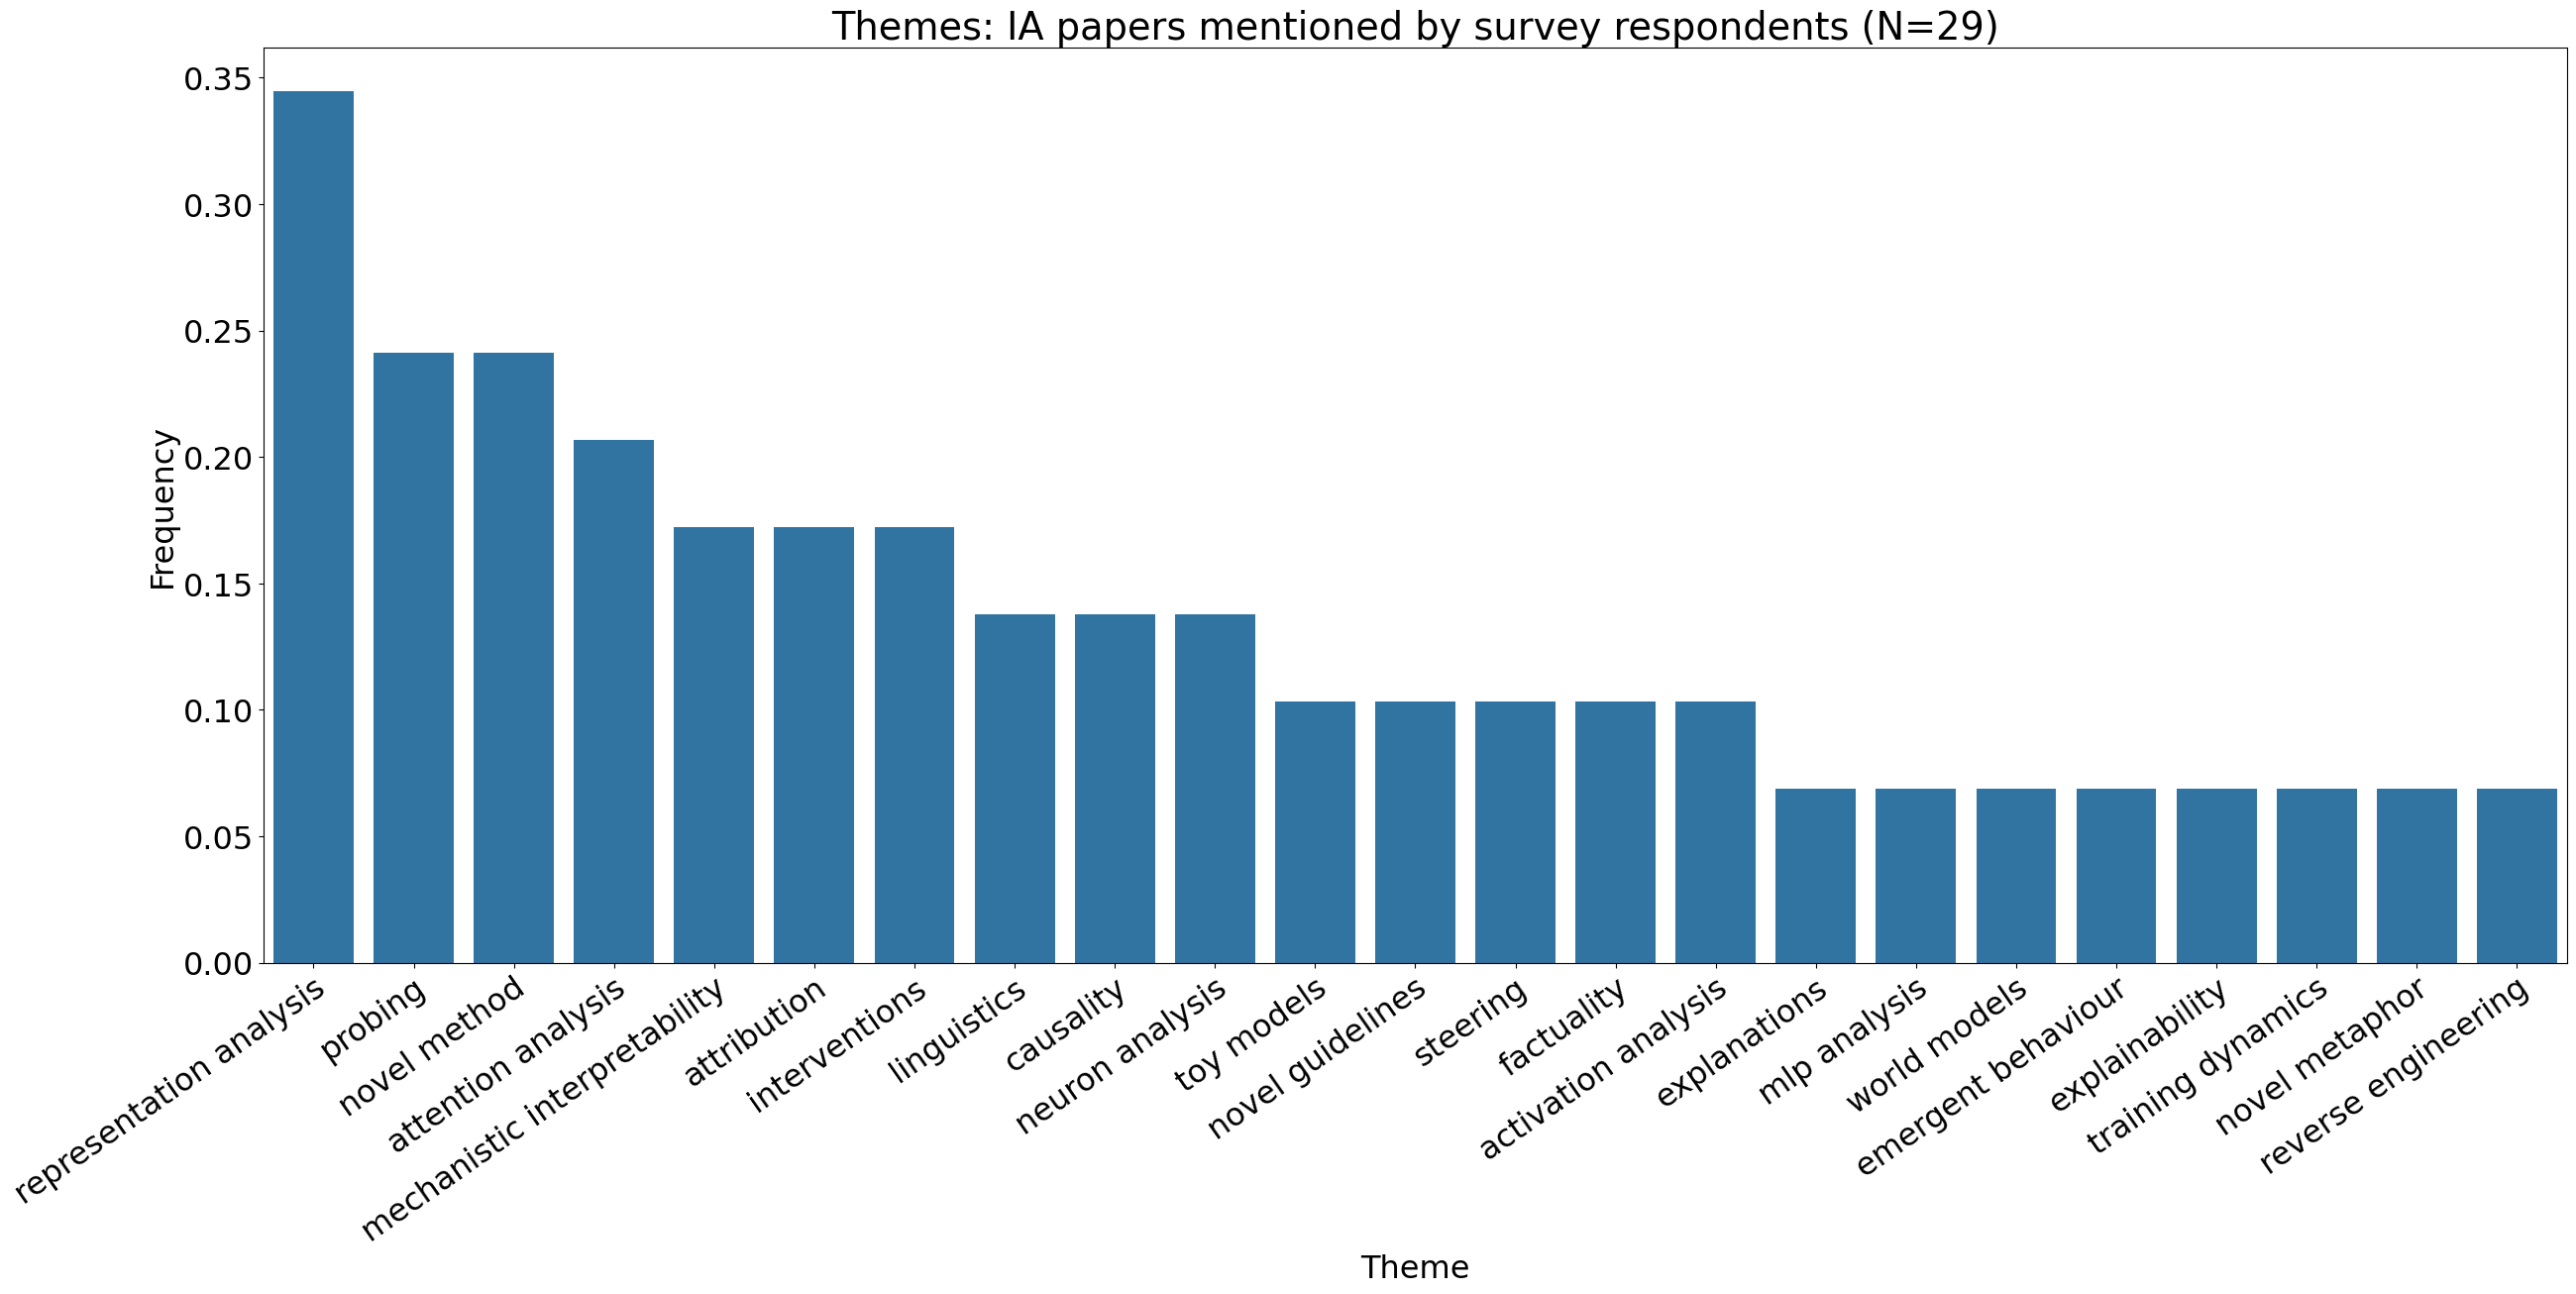

In [25]:
sorted_df = get_sorted_themes_df(survey_interp_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 1]
sorted_df[1] = sorted_df[1]/len(survey_interp_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: IA papers mentioned by survey respondents (N=29)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

In [26]:
sorted_df.head()

0         1
0       representation analysis  0.344828
1                       probing  0.241379
2                  novel method  0.241379
3            attention analysis  0.206897
4  mechanistic interpretability  0.172414

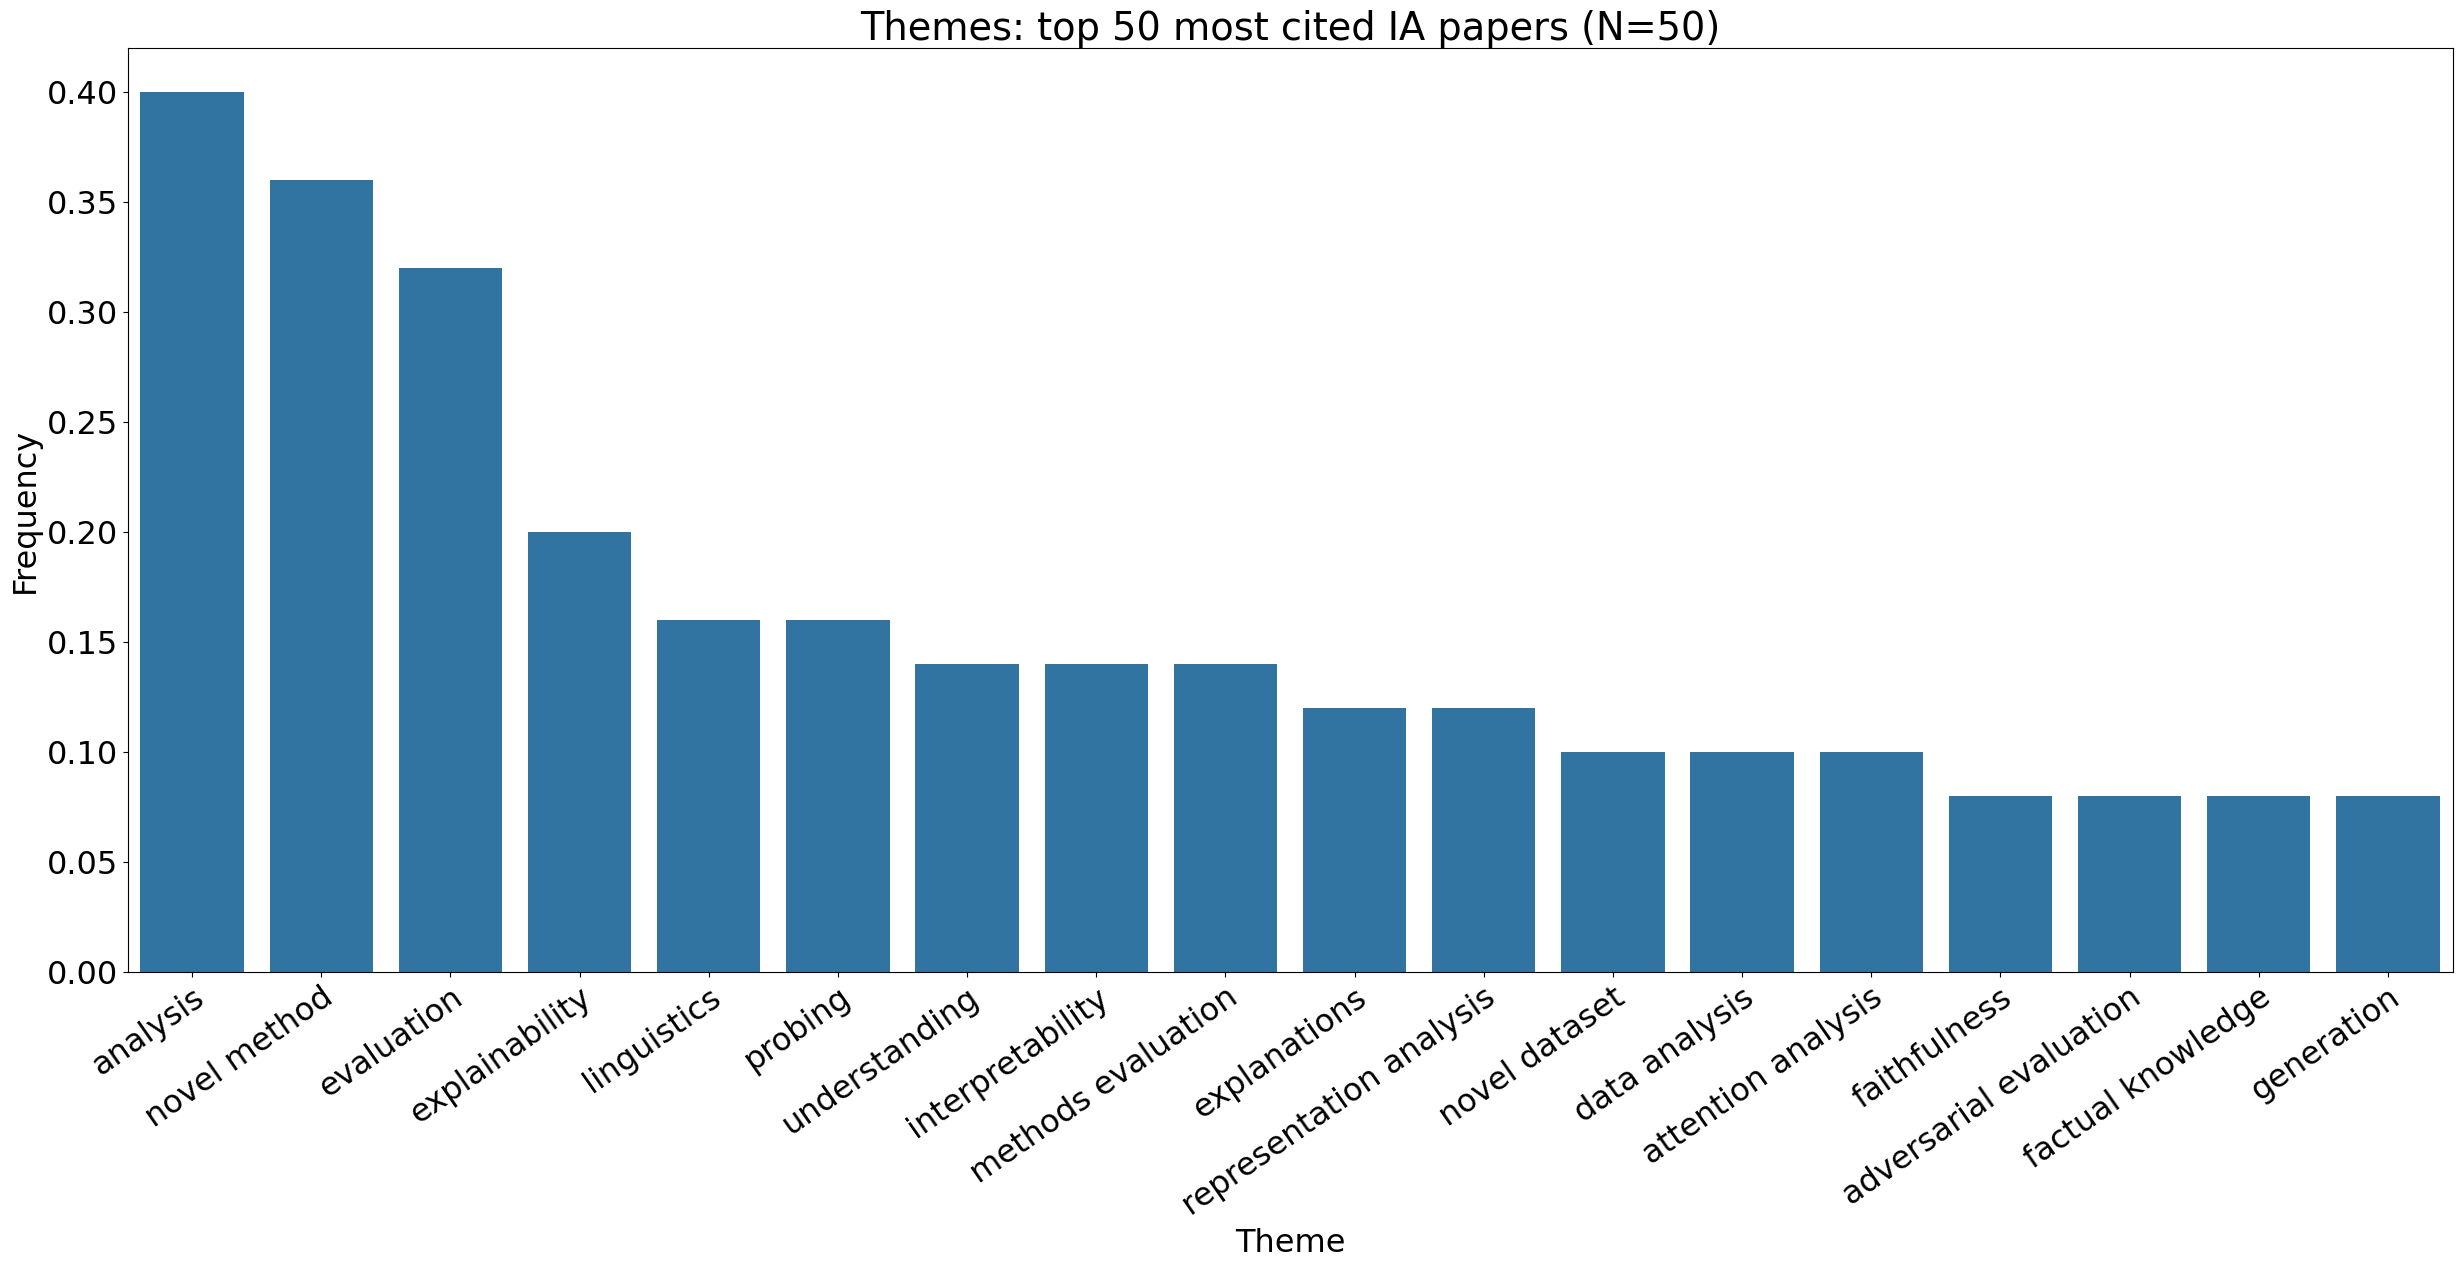

In [27]:
sorted_df = get_sorted_themes_df(top50_interp_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 3]
sorted_df[1] = sorted_df[1]/len(top50_interp_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: top 50 most cited IA papers (N=50)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

In [28]:
sorted_df.head()

0     1
0        analysis  0.40
1    novel method  0.36
2      evaluation  0.32
3  explainability  0.20
4     linguistics  0.16

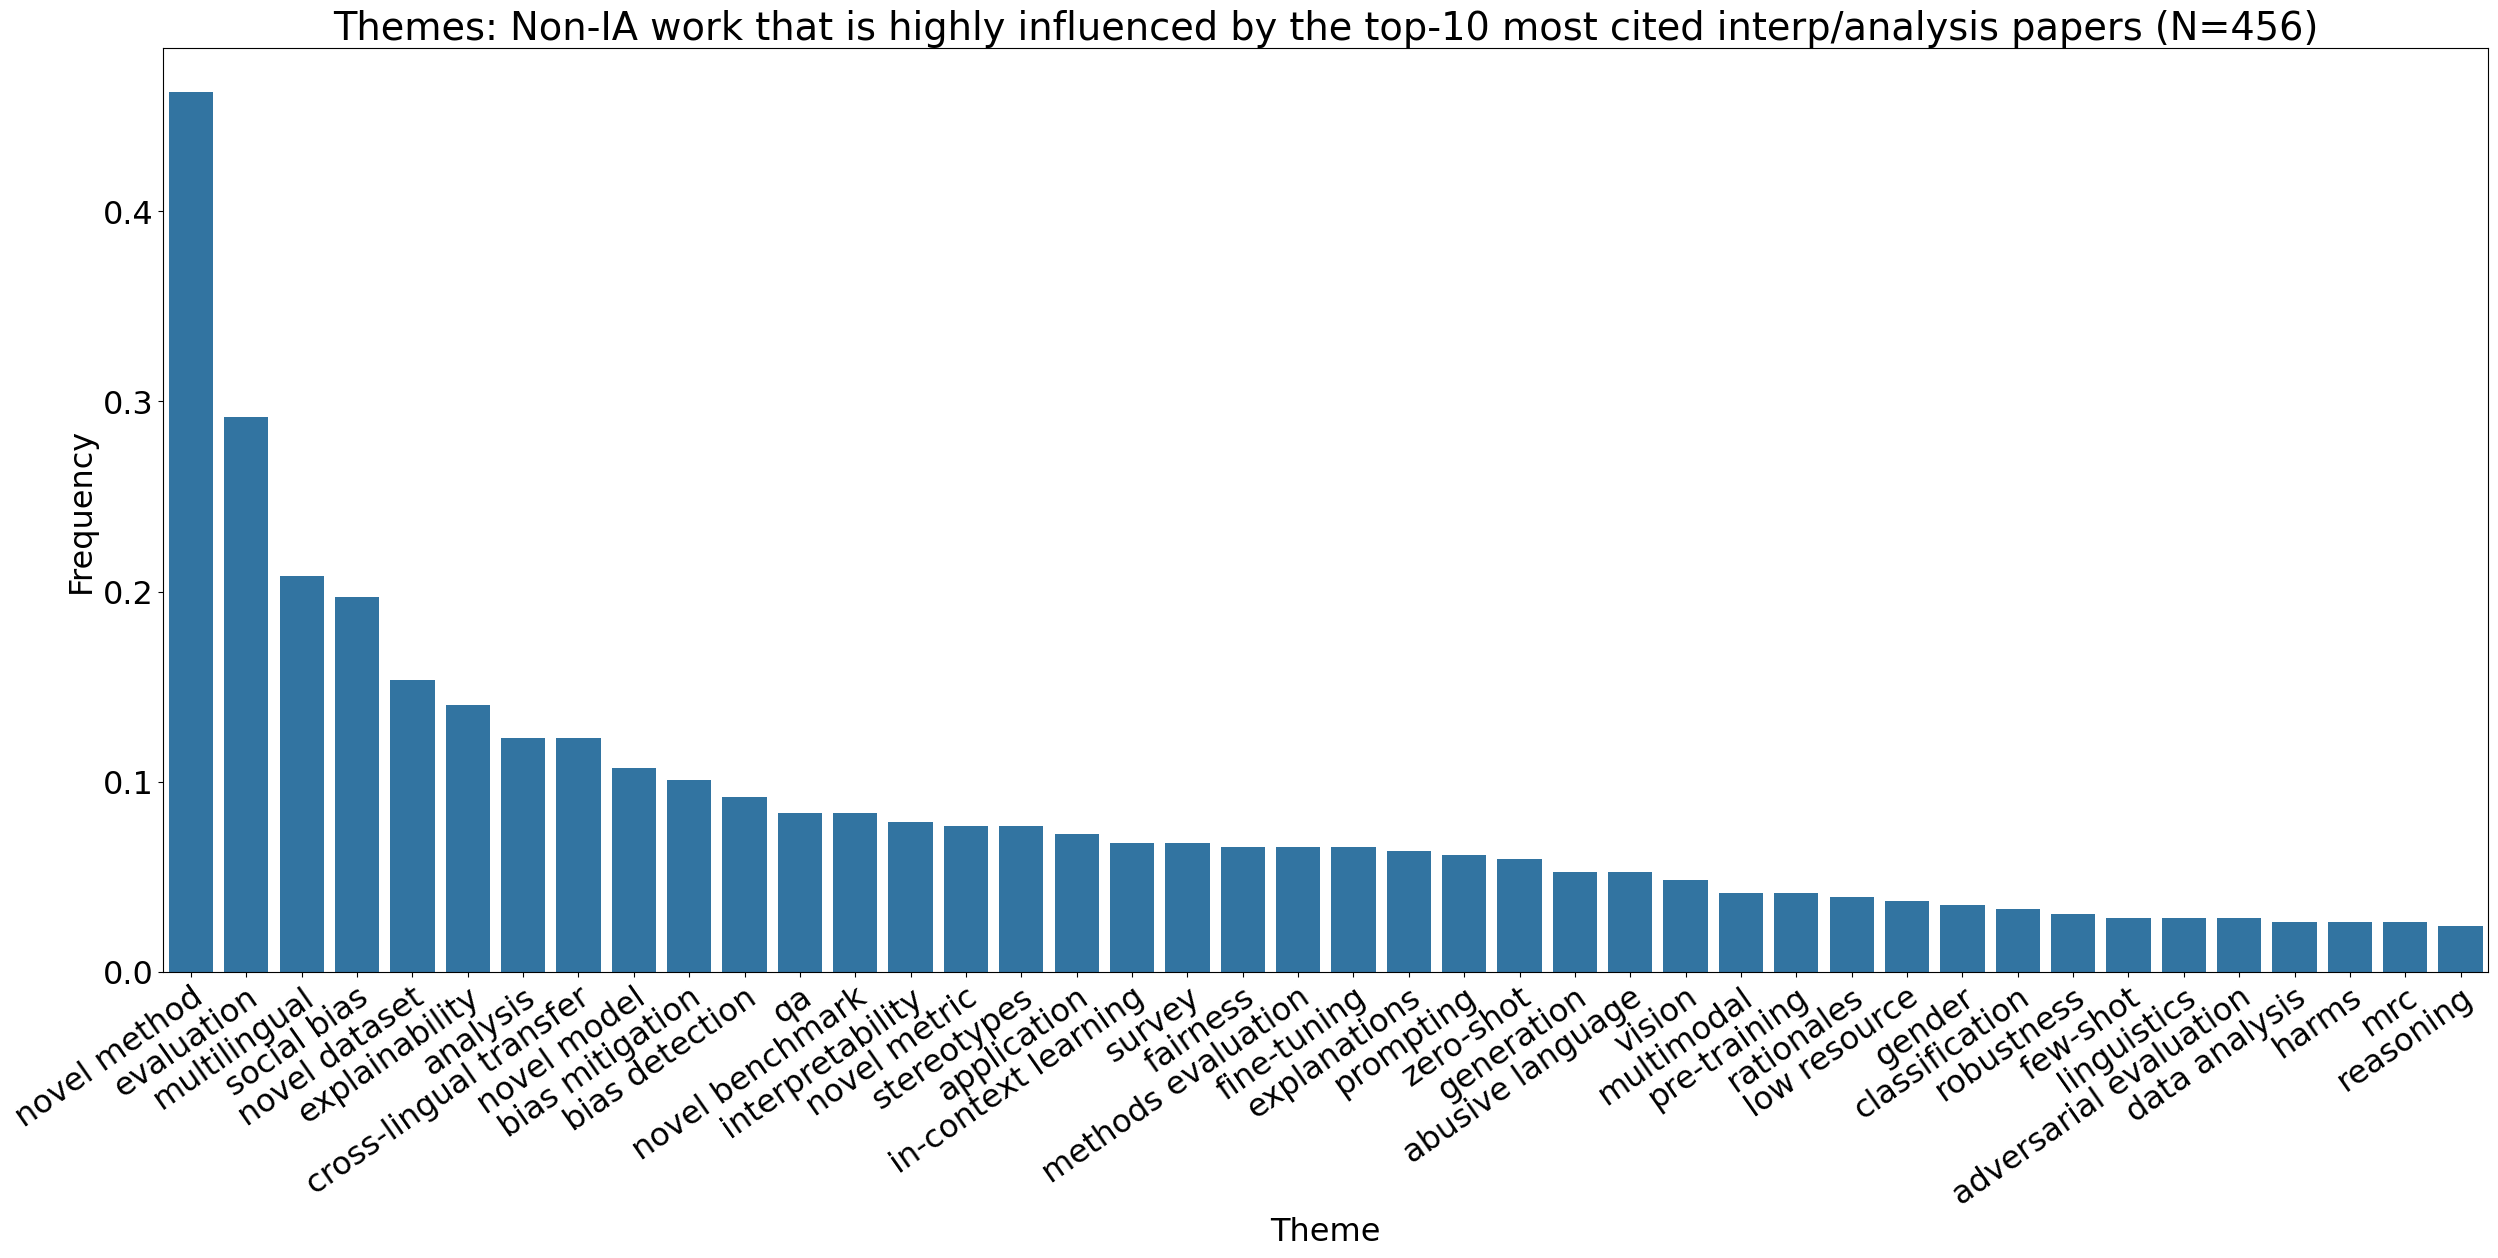

In [29]:
sorted_df = get_sorted_themes_df(citations_to_top50_interp_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 10]
sorted_df[1] = sorted_df[1]/len(citations_to_top50_interp_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: Non-IA work that is highly influenced by the top-10 most cited interp/analysis papers (N=456)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

In [30]:
sorted_df.head()

0         1
0   novel method  0.462719
1     evaluation  0.291667
2   multilingual  0.208333
3    social bias  0.197368
4  novel dataset  0.153509

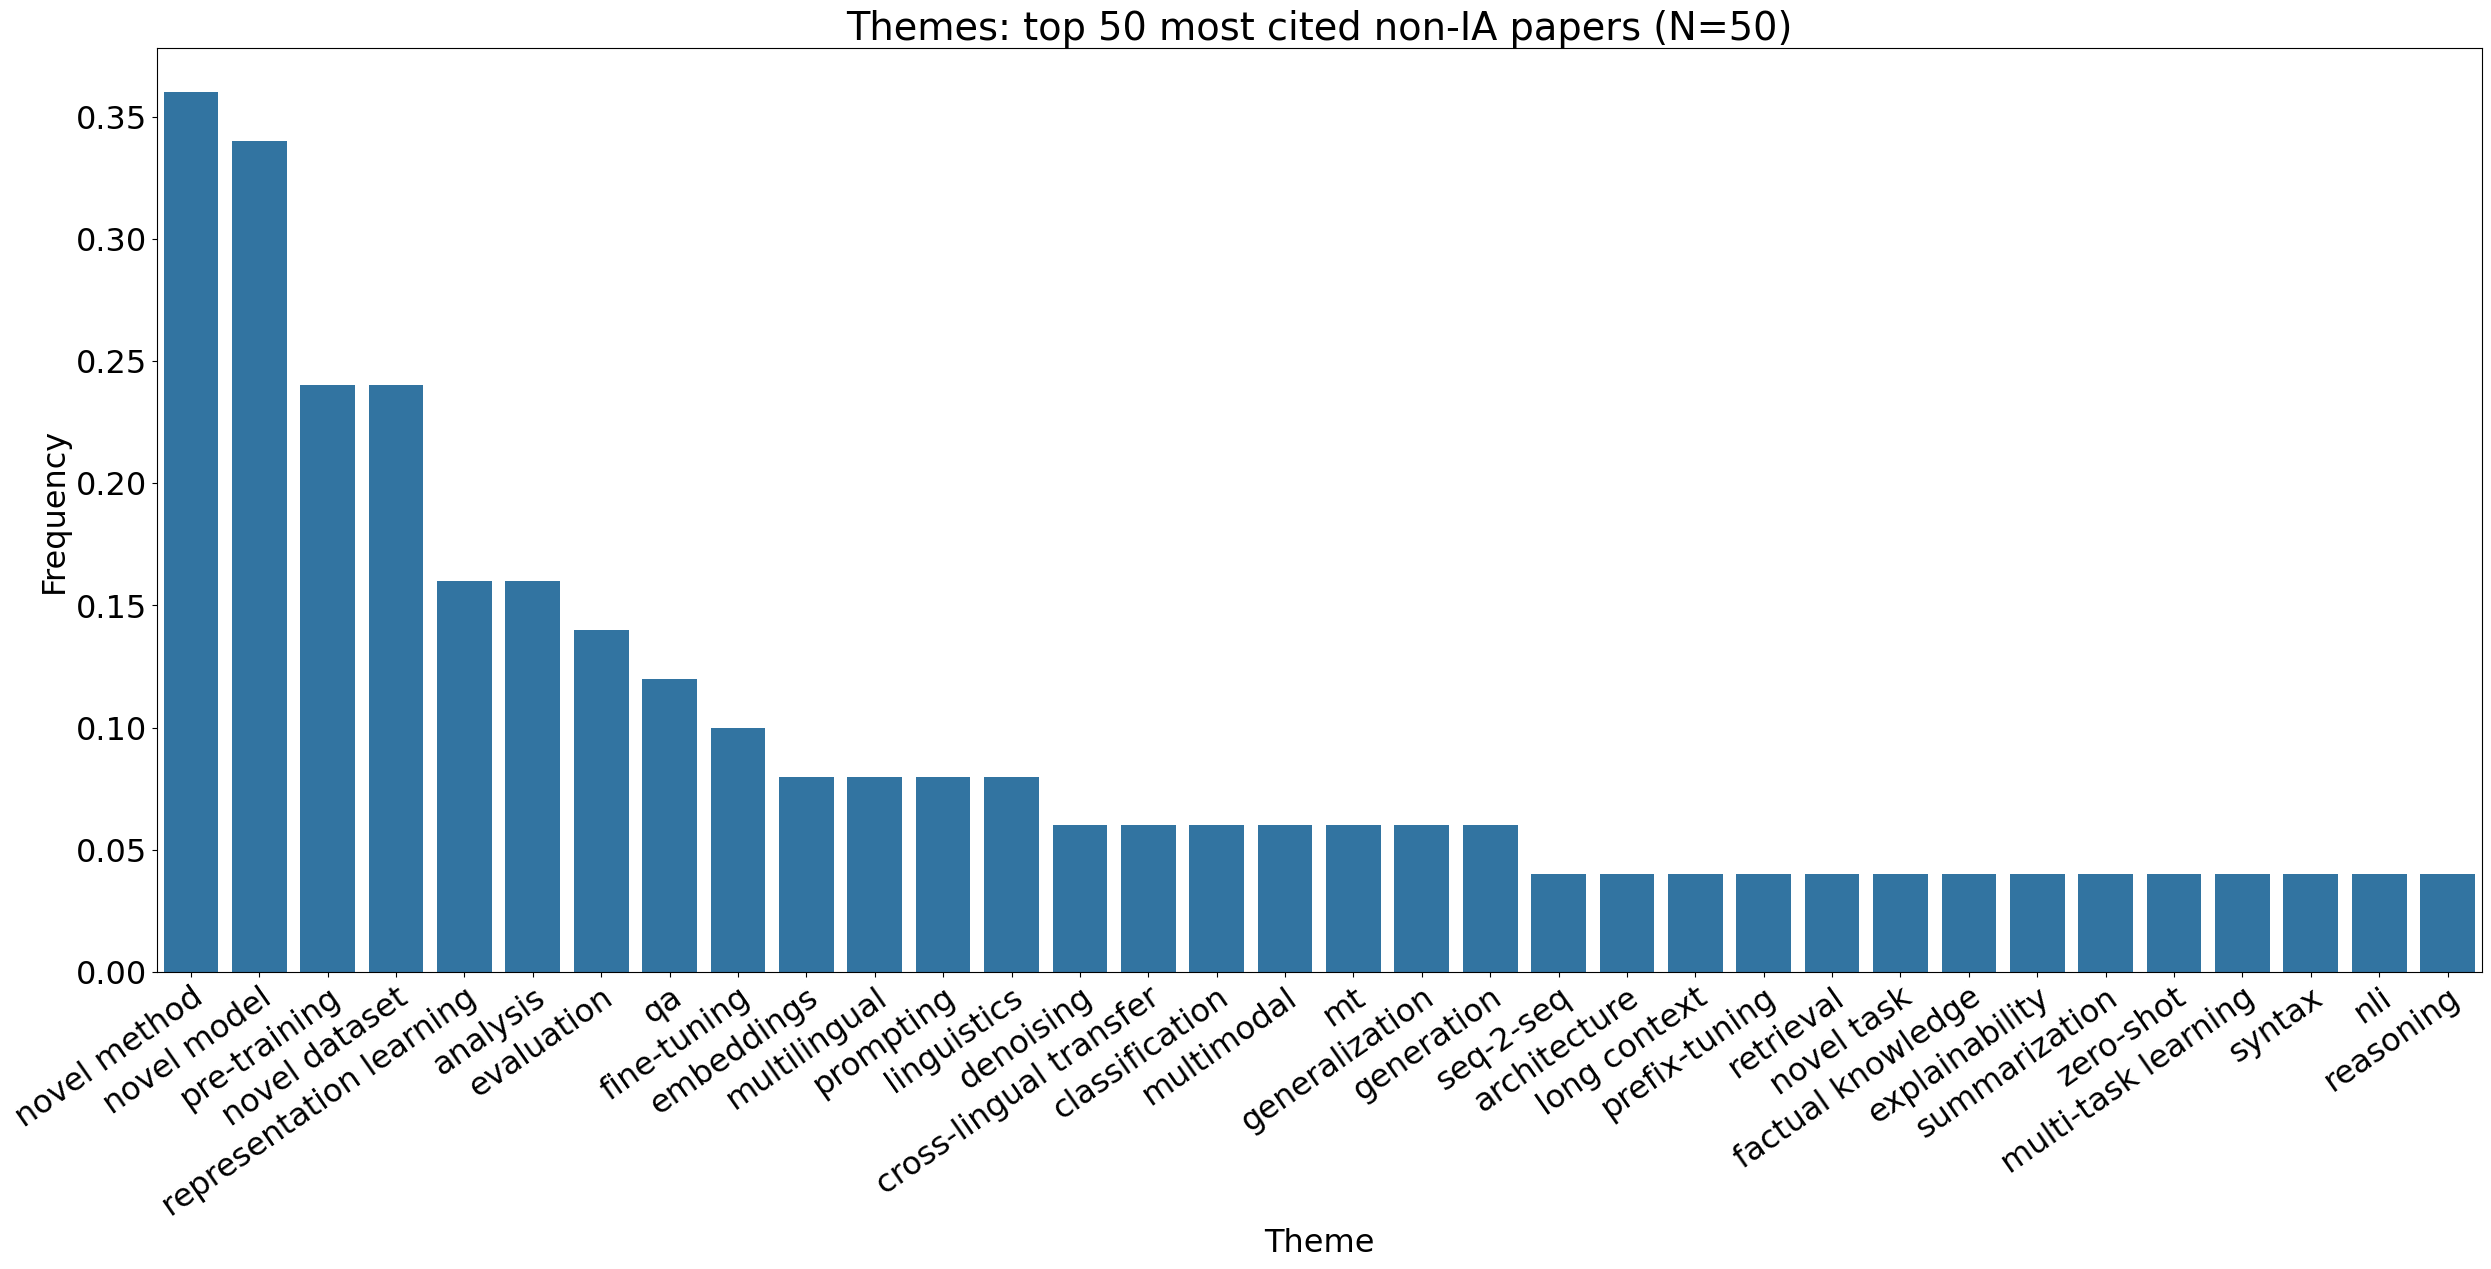

In [31]:
sorted_df = get_sorted_themes_df(top50_other_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 1]
sorted_df[1] = sorted_df[1]/len(top50_other_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: top 50 most cited non-IA papers (N=50)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

In [32]:
sorted_df.head()

0     1
0             novel method  0.36
1              novel model  0.34
2             pre-training  0.24
3            novel dataset  0.24
4  representation learning  0.16

## Zooming in on novel method and novel model

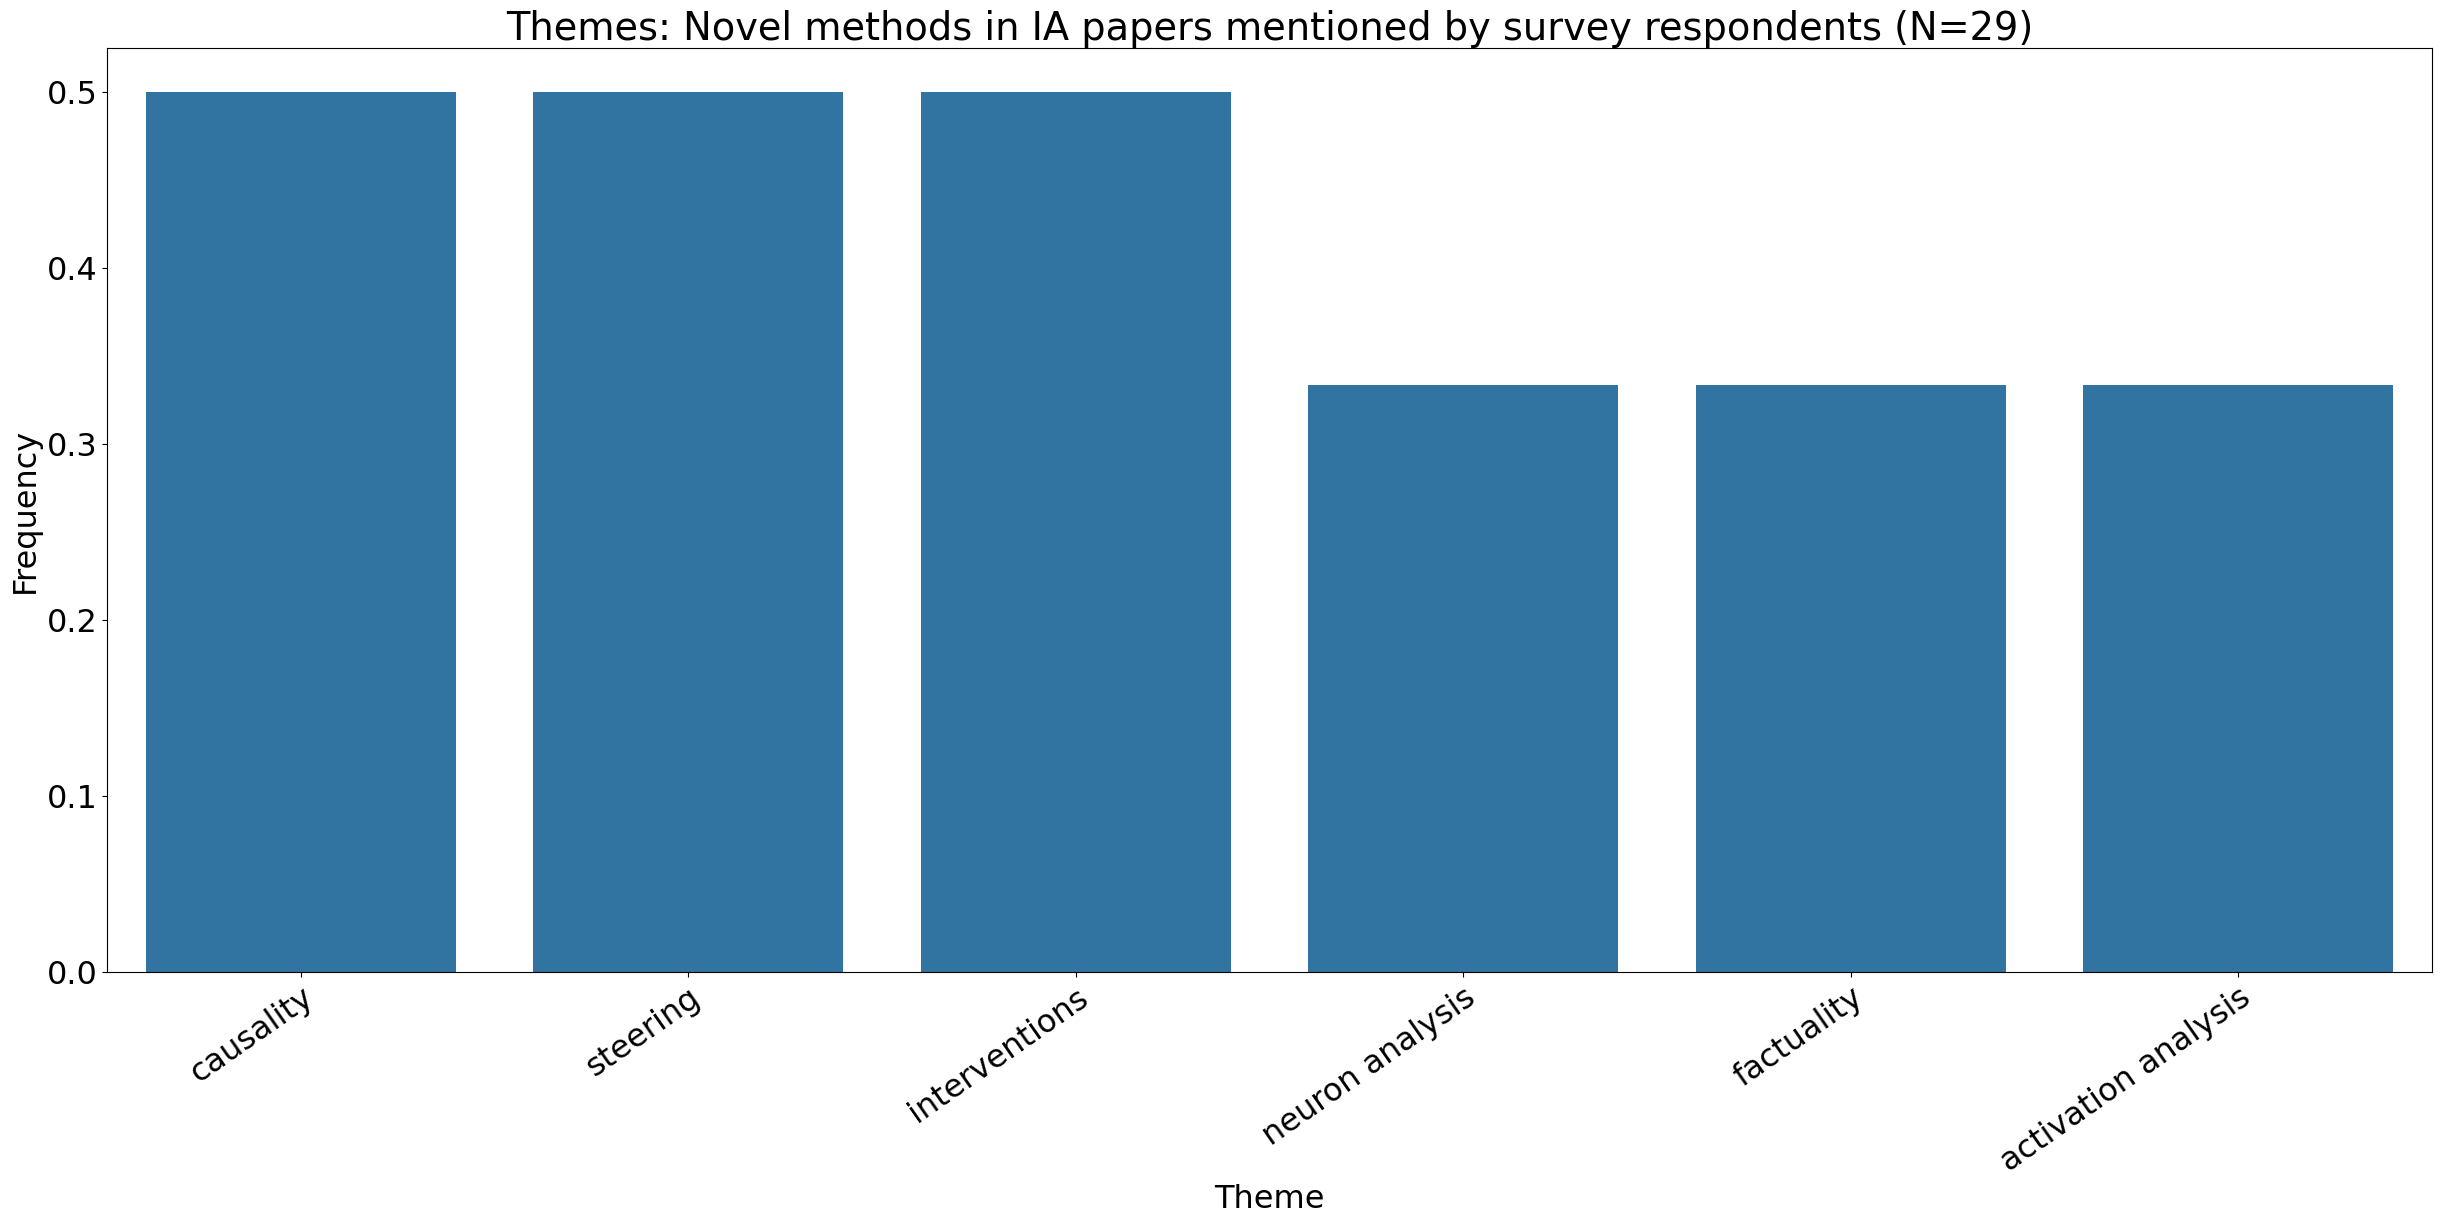

In [33]:
novel_method_df = survey_interp_df[survey_interp_df.marius_themes.str.contains('novel method') | survey_interp_df.vagrant_themes.str.contains('novel method')]
sorted_df = get_sorted_themes_df(novel_method_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 1]
sorted_df[1] = sorted_df[1]/len(novel_method_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df[1:], x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: Novel methods in IA papers mentioned by survey respondents (N=29)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

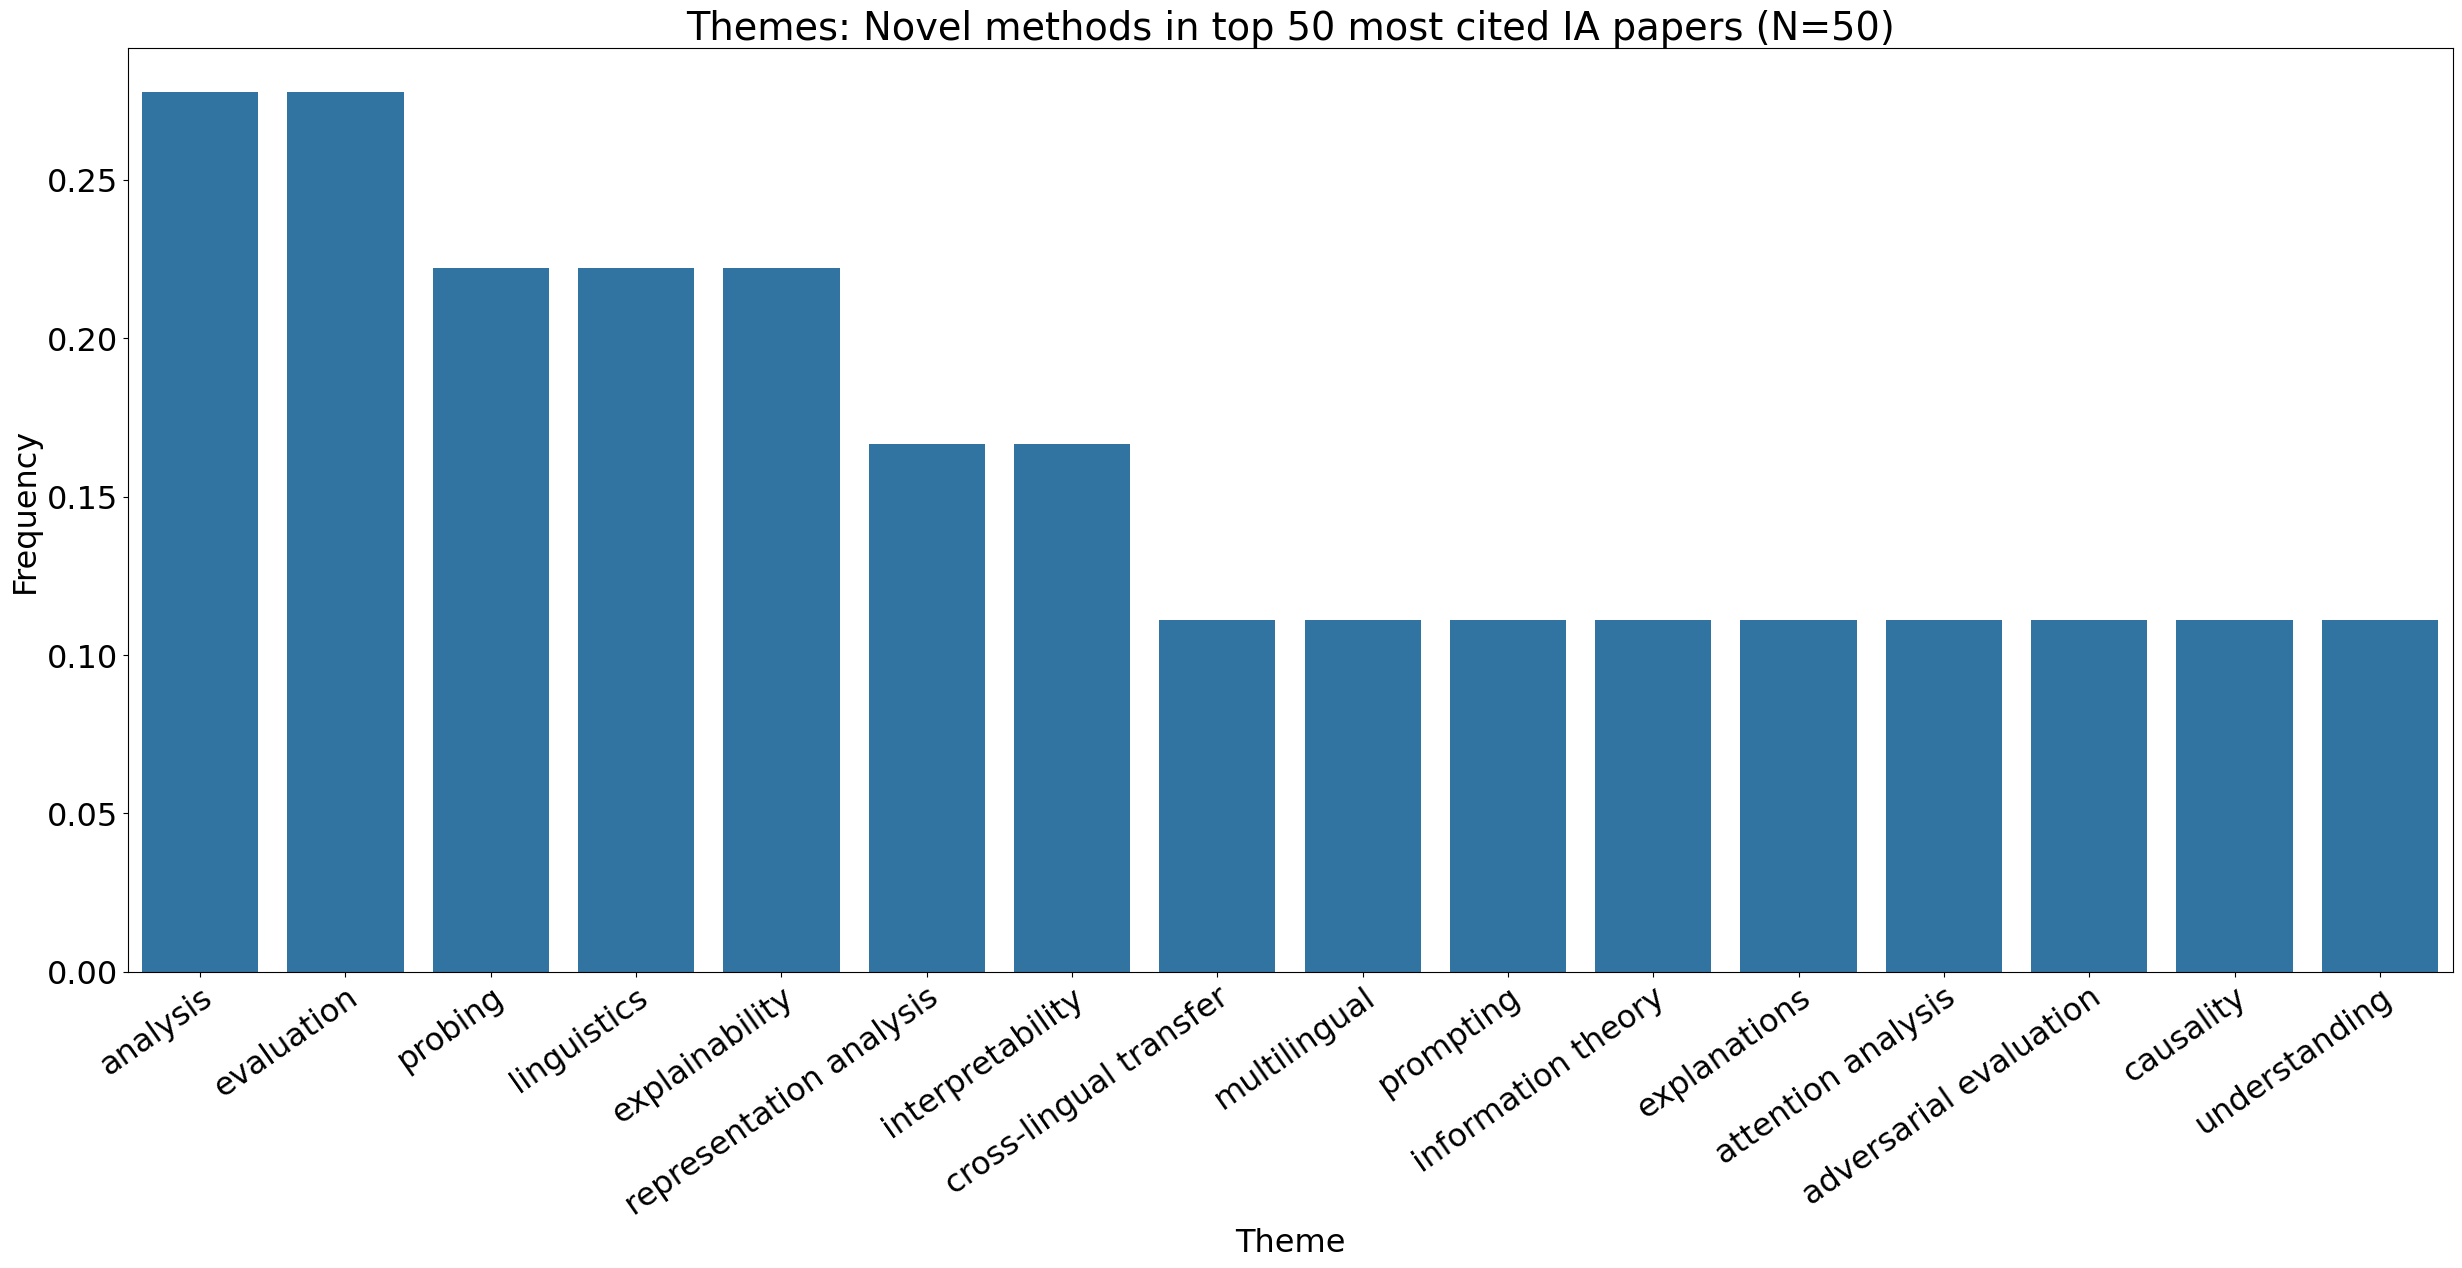

In [34]:
novel_method_df = top50_interp_df[top50_interp_df.marius_themes.str.contains('novel method') | top50_interp_df.vagrant_themes.str.contains('novel method')]
sorted_df = get_sorted_themes_df(novel_method_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 1]
sorted_df[1] = sorted_df[1]/len(novel_method_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df[1:], x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: Novel methods in top 50 most cited IA papers (N=50)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

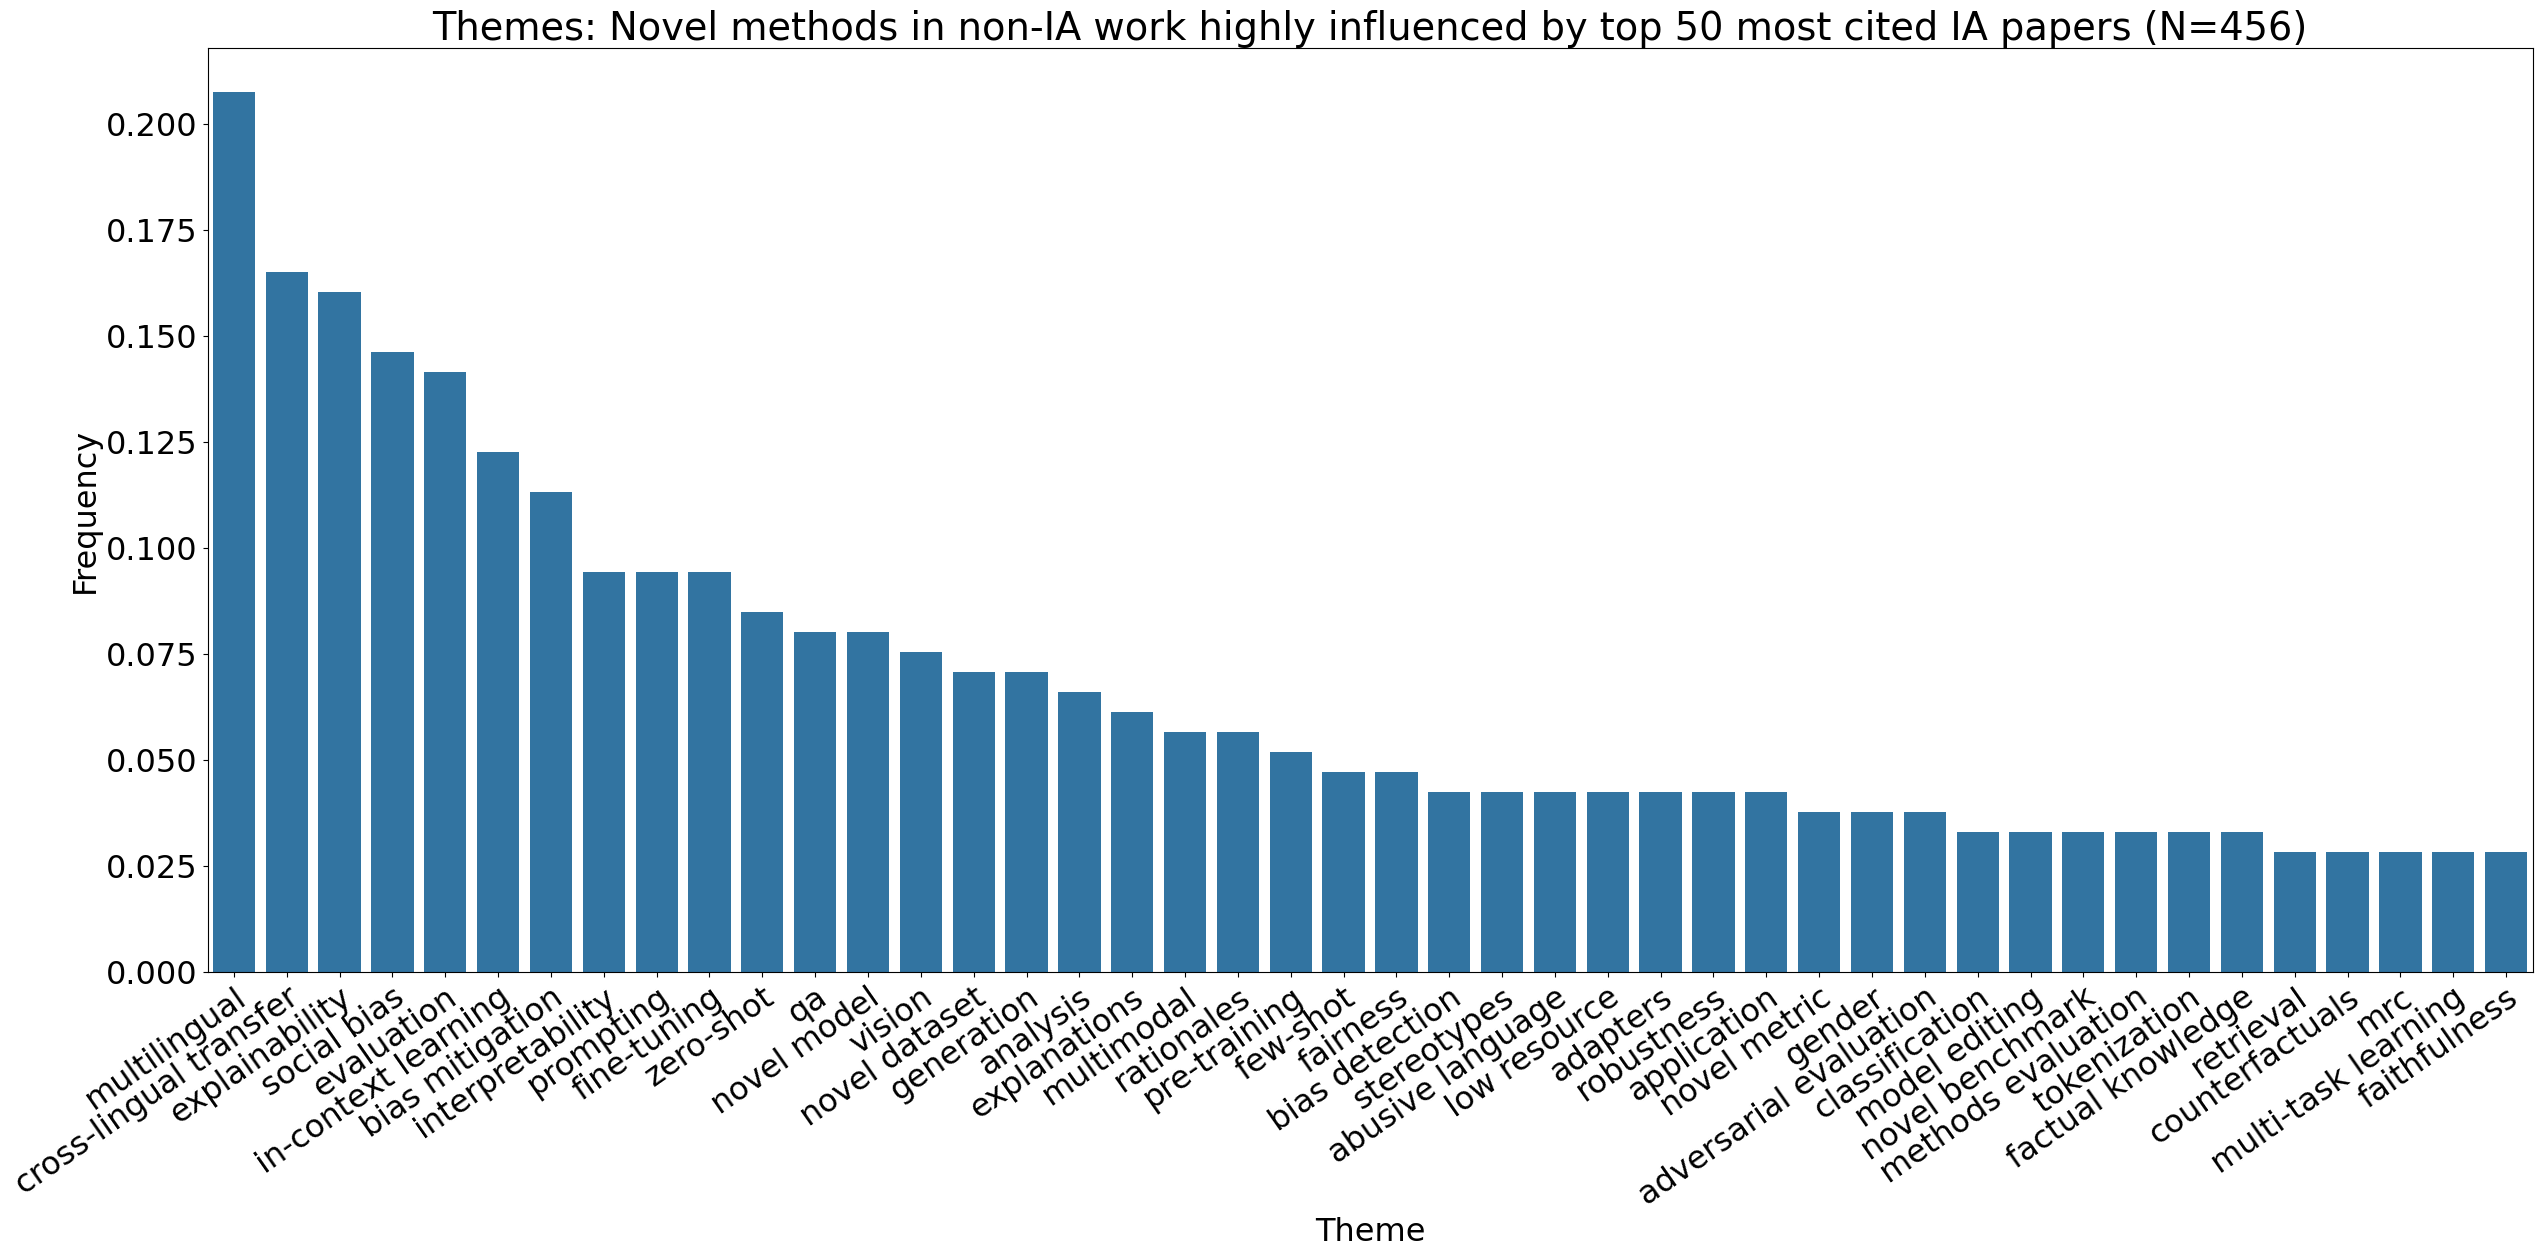

In [35]:
novel_method_df = citations_to_top50_interp_df[citations_to_top50_interp_df.marius_themes.str.contains('novel method') | citations_to_top50_interp_df.vagrant_themes.str.contains('novel method')]
sorted_df = get_sorted_themes_df(novel_method_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 5]
sorted_df[1] = sorted_df[1]/len(novel_method_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df[1:], x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: Novel methods in non-IA work highly influenced by top 50 most cited IA papers (N=456)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

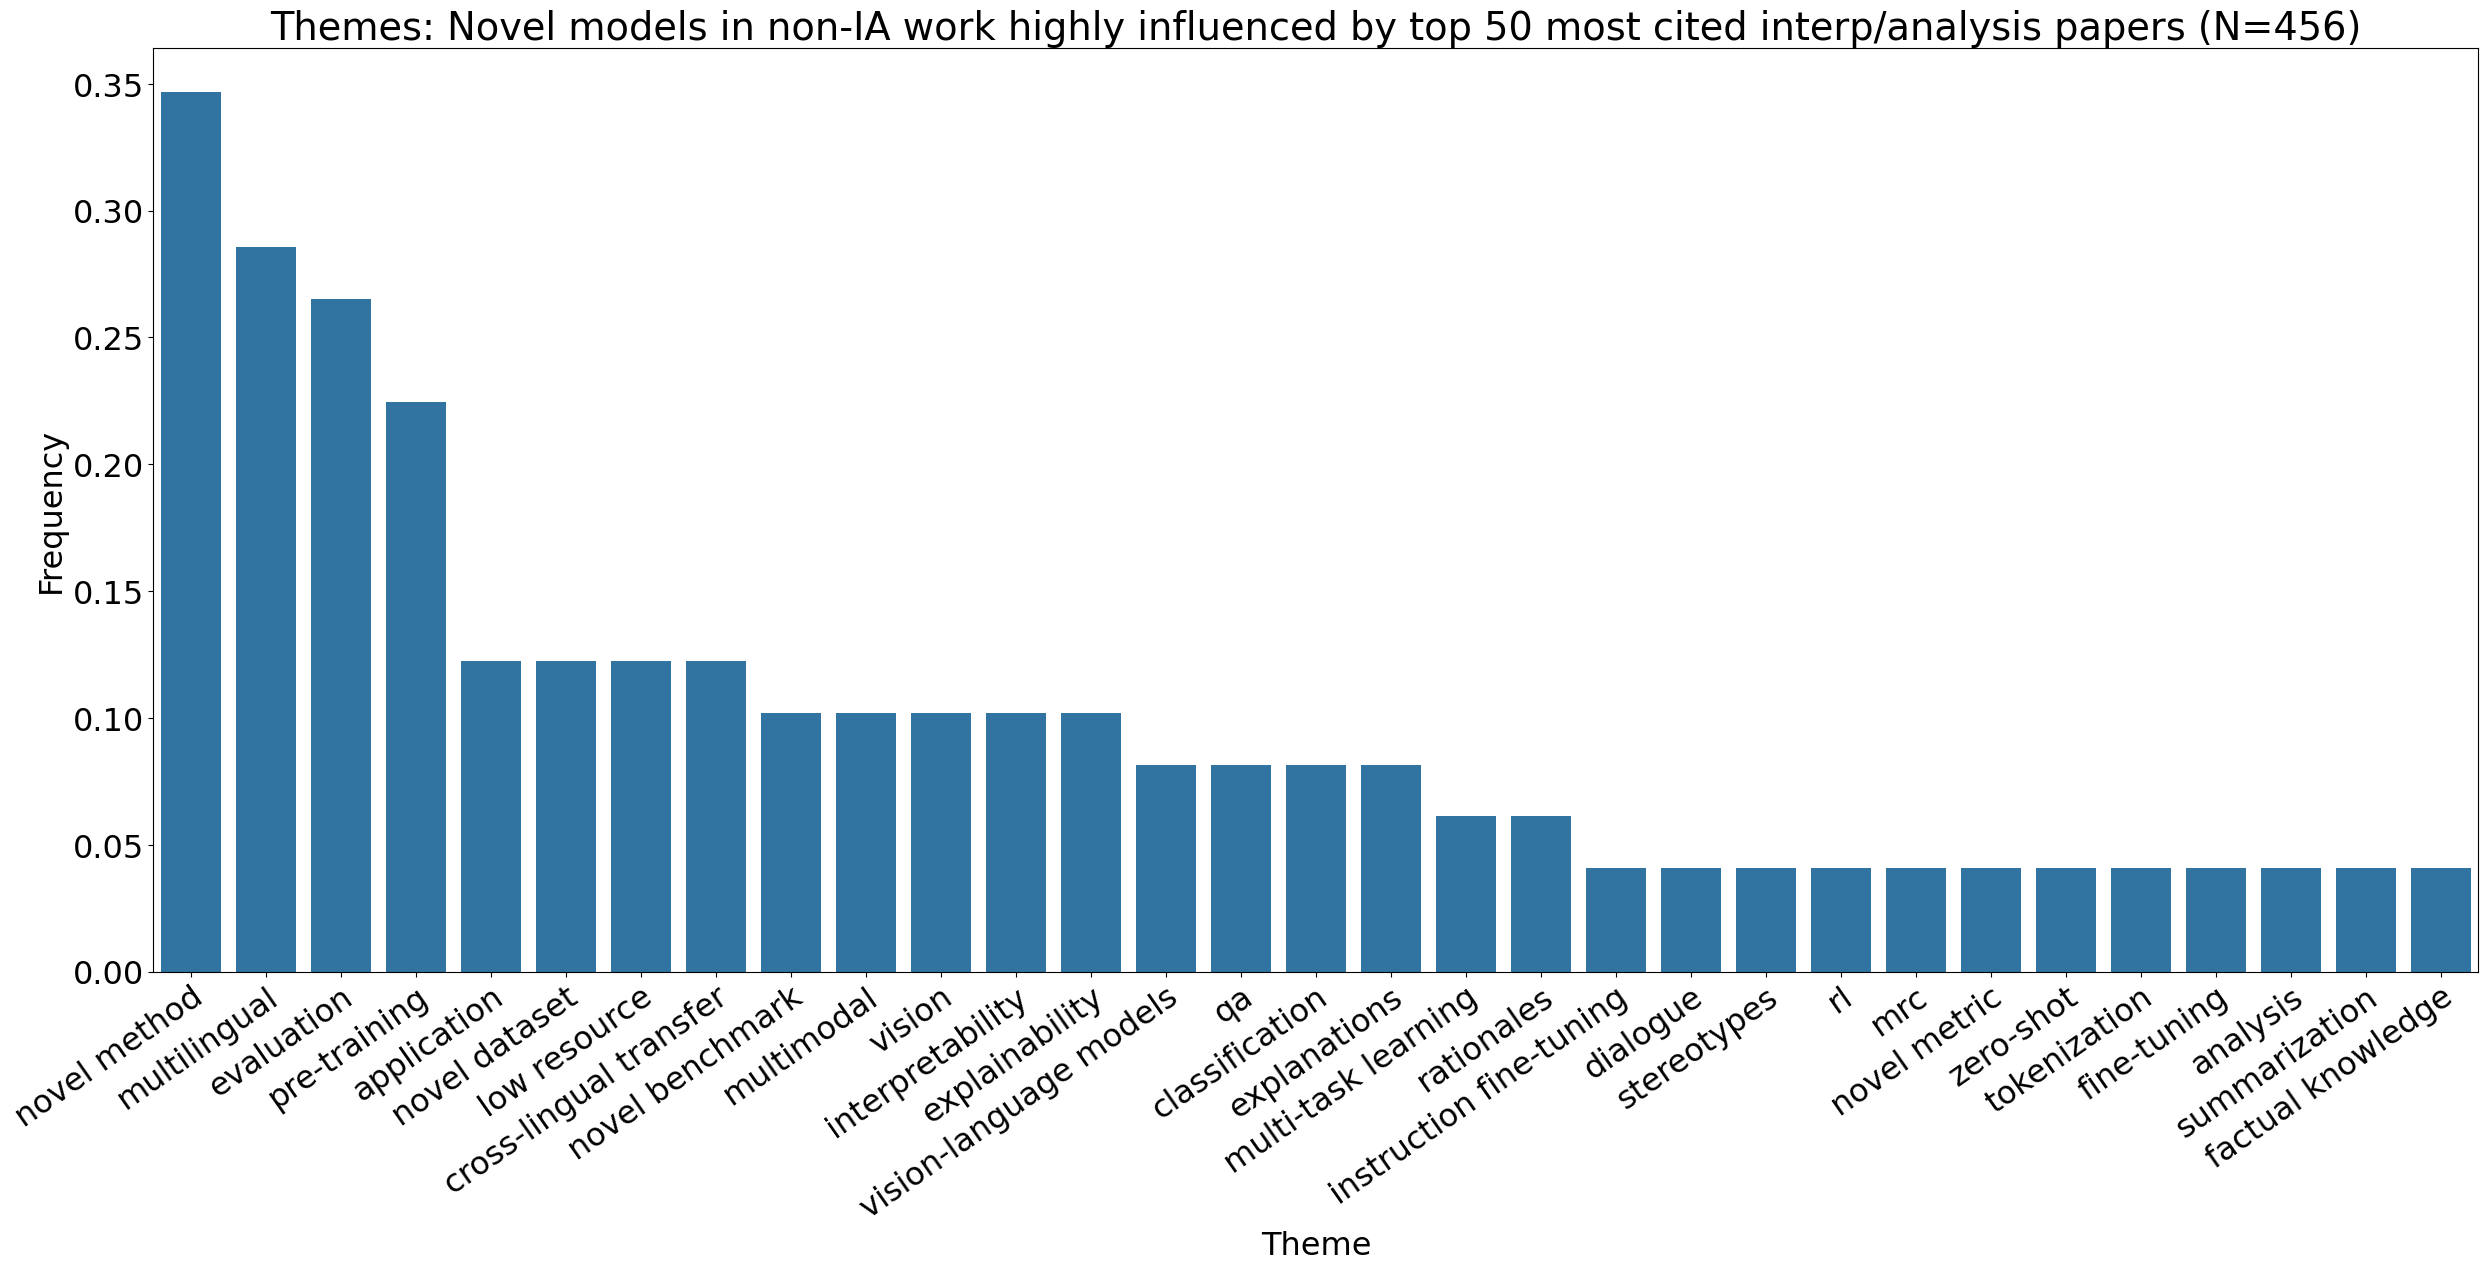

In [36]:
novel_model_df = citations_to_top50_interp_df[citations_to_top50_interp_df.marius_themes.str.contains('novel model') | citations_to_top50_interp_df.vagrant_themes.str.contains('novel model')]
sorted_df = get_sorted_themes_df(novel_model_df, papers_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 1]
sorted_df[1] = sorted_df[1]/len(novel_model_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df[1:], x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: Novel models in non-IA work highly influenced by top 50 most cited interp/analysis papers (N=456)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

## Comparison of themes between citing and cited papers (intersection and diff)

In [37]:
merged_df = top50_interp_df.merge(citations_to_top50_interp_df,
                      left_on='title',
                      right_on='cited_paper_title')[['title', 'citing_paper_title',
                                                     'marius_themes_x', 'vagrant_themes_x',
                                                     'marius_themes_y','vagrant_themes_y']]

In [38]:
def process_merged(df):
    df['marius_vagrant_themes_x'] = df['marius_themes_x'].str.cat(df['marius_themes_x'], sep=',')
    df['marius_vagrant_themes_y'] = df['marius_themes_y'].str.cat(df['marius_themes_y'], sep=',')
    df['intersection'] = df.apply(lambda row: ','.join(list(set(row['marius_vagrant_themes_x'].split(',')).intersection(set(row['marius_vagrant_themes_y'].split(','))))), axis=1)
    df['diff'] = df.apply(lambda row: ','.join(list(set(row['marius_vagrant_themes_y'].split(',')).difference(set(row['marius_vagrant_themes_x'].split(','))))), axis=1)
    return df

In [39]:
process_merged_df = merged_df.groupby('title', group_keys=False).apply(process_merged)

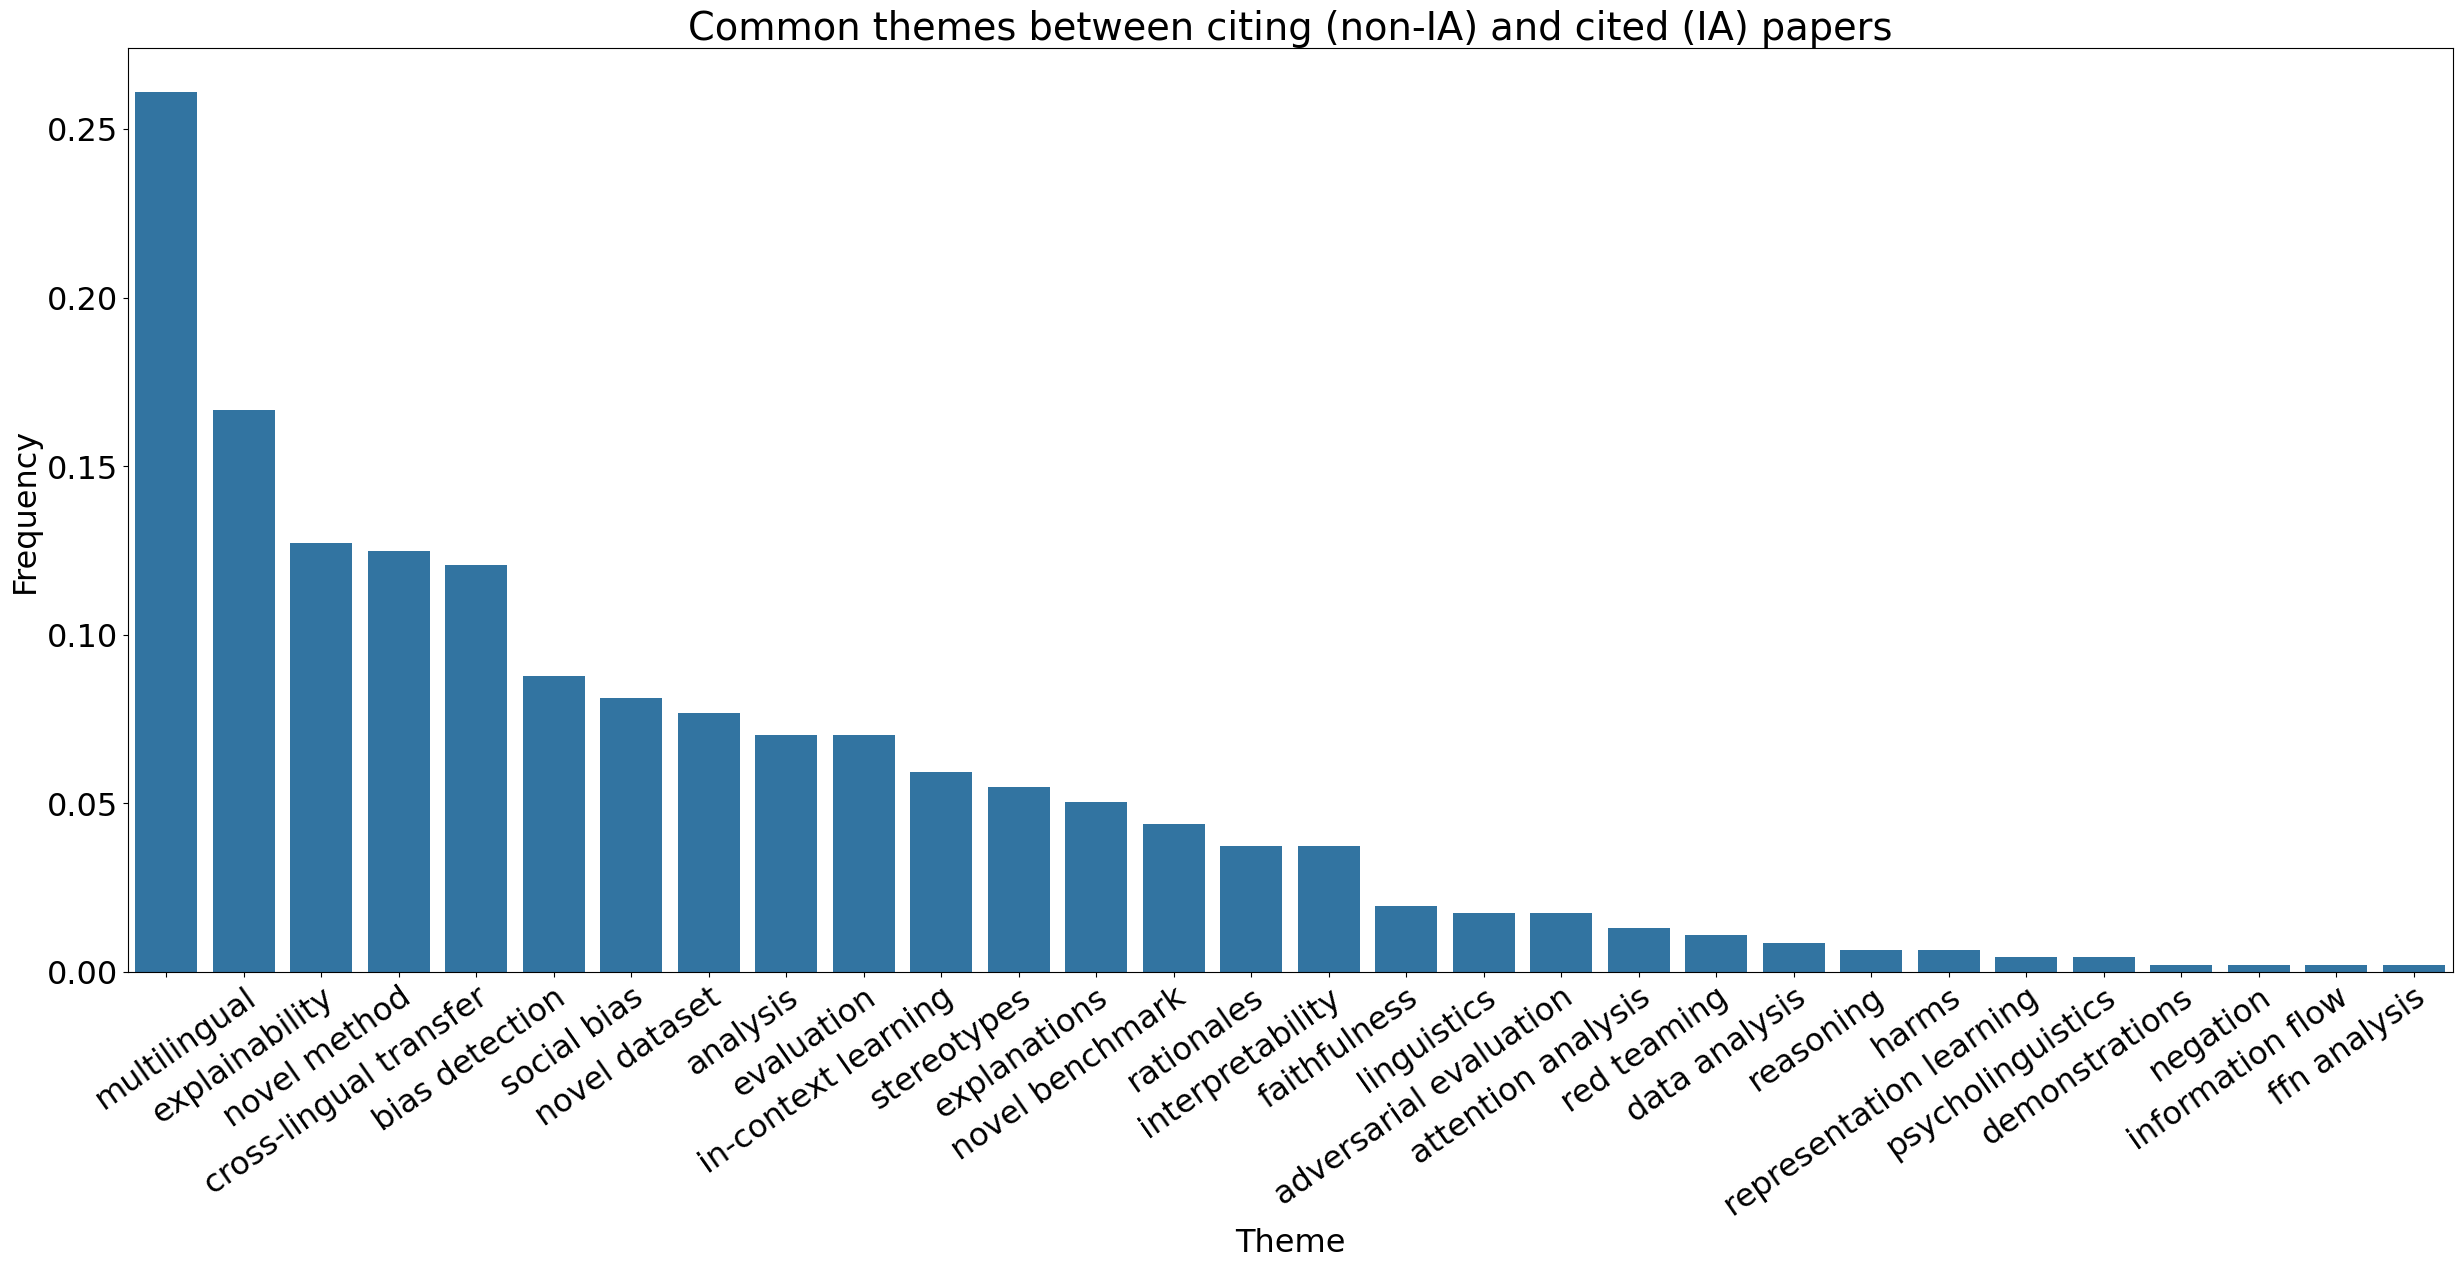

In [40]:
sorted_df = get_sorted_themes_df(process_merged_df, papers_normalizing_dict, 'intersection')
sorted_df[1] = sorted_df[1]/len(process_merged_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Common themes between citing (non-IA) and cited (IA) papers")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

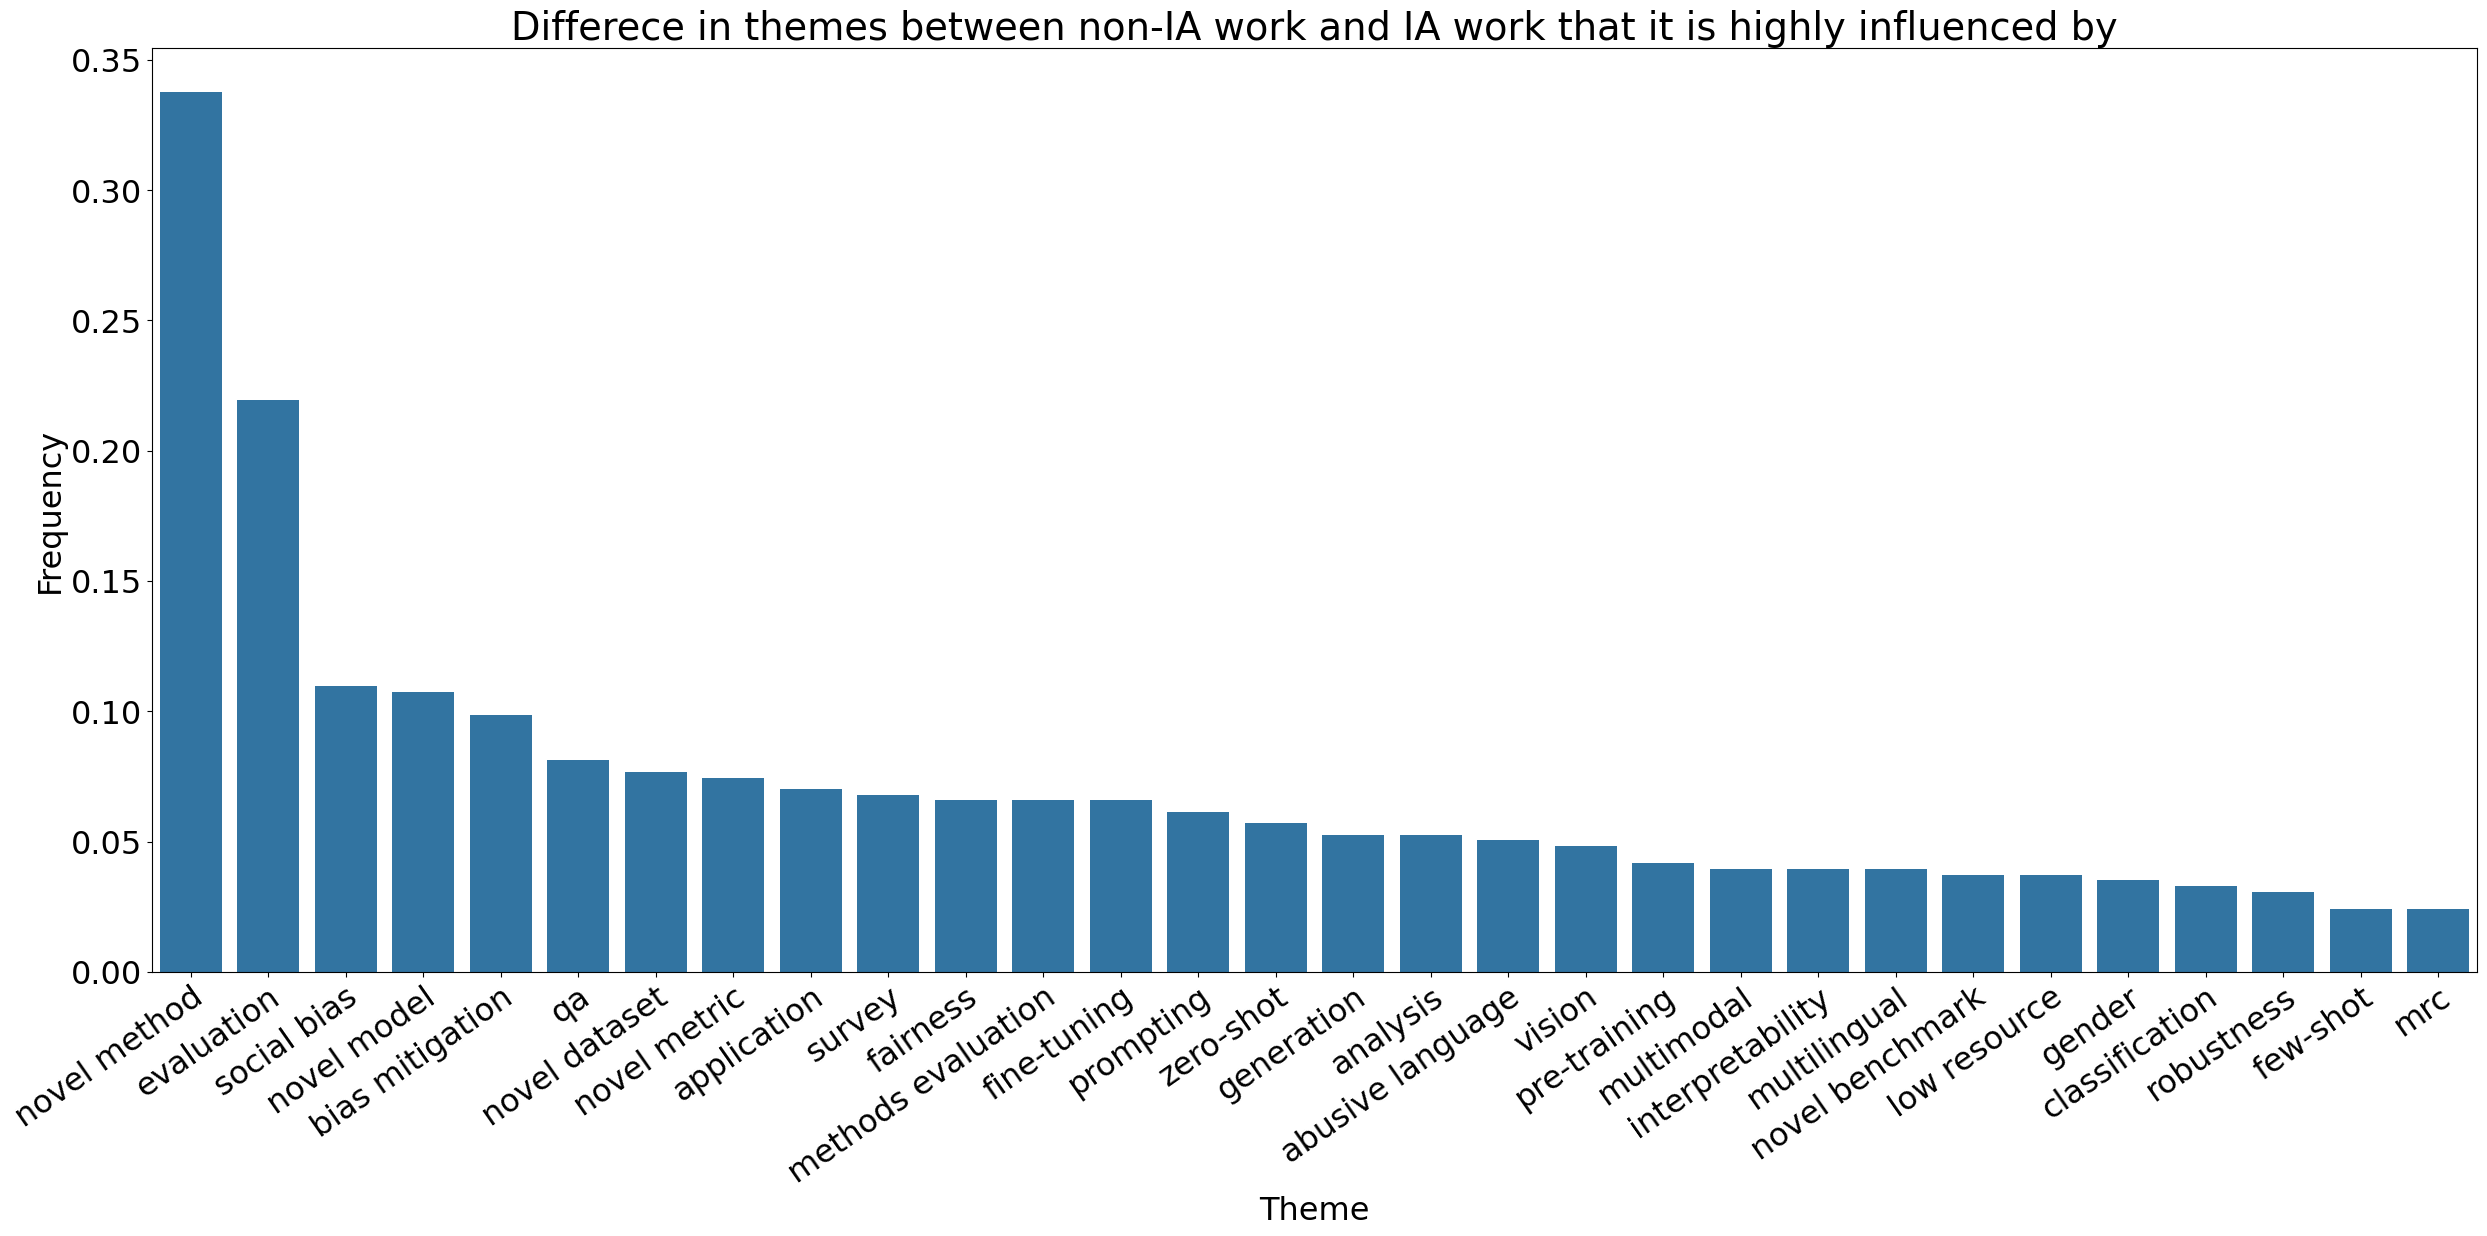

In [41]:
sorted_df = get_sorted_themes_df(process_merged_df, papers_normalizing_dict, 'diff')
sorted_df = sorted_df[sorted_df[1] > 10]
sorted_df[1] = sorted_df[1]/len(process_merged_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Differece in themes between non-IA work and IA work that it is highly influenced by")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

## Survey responses

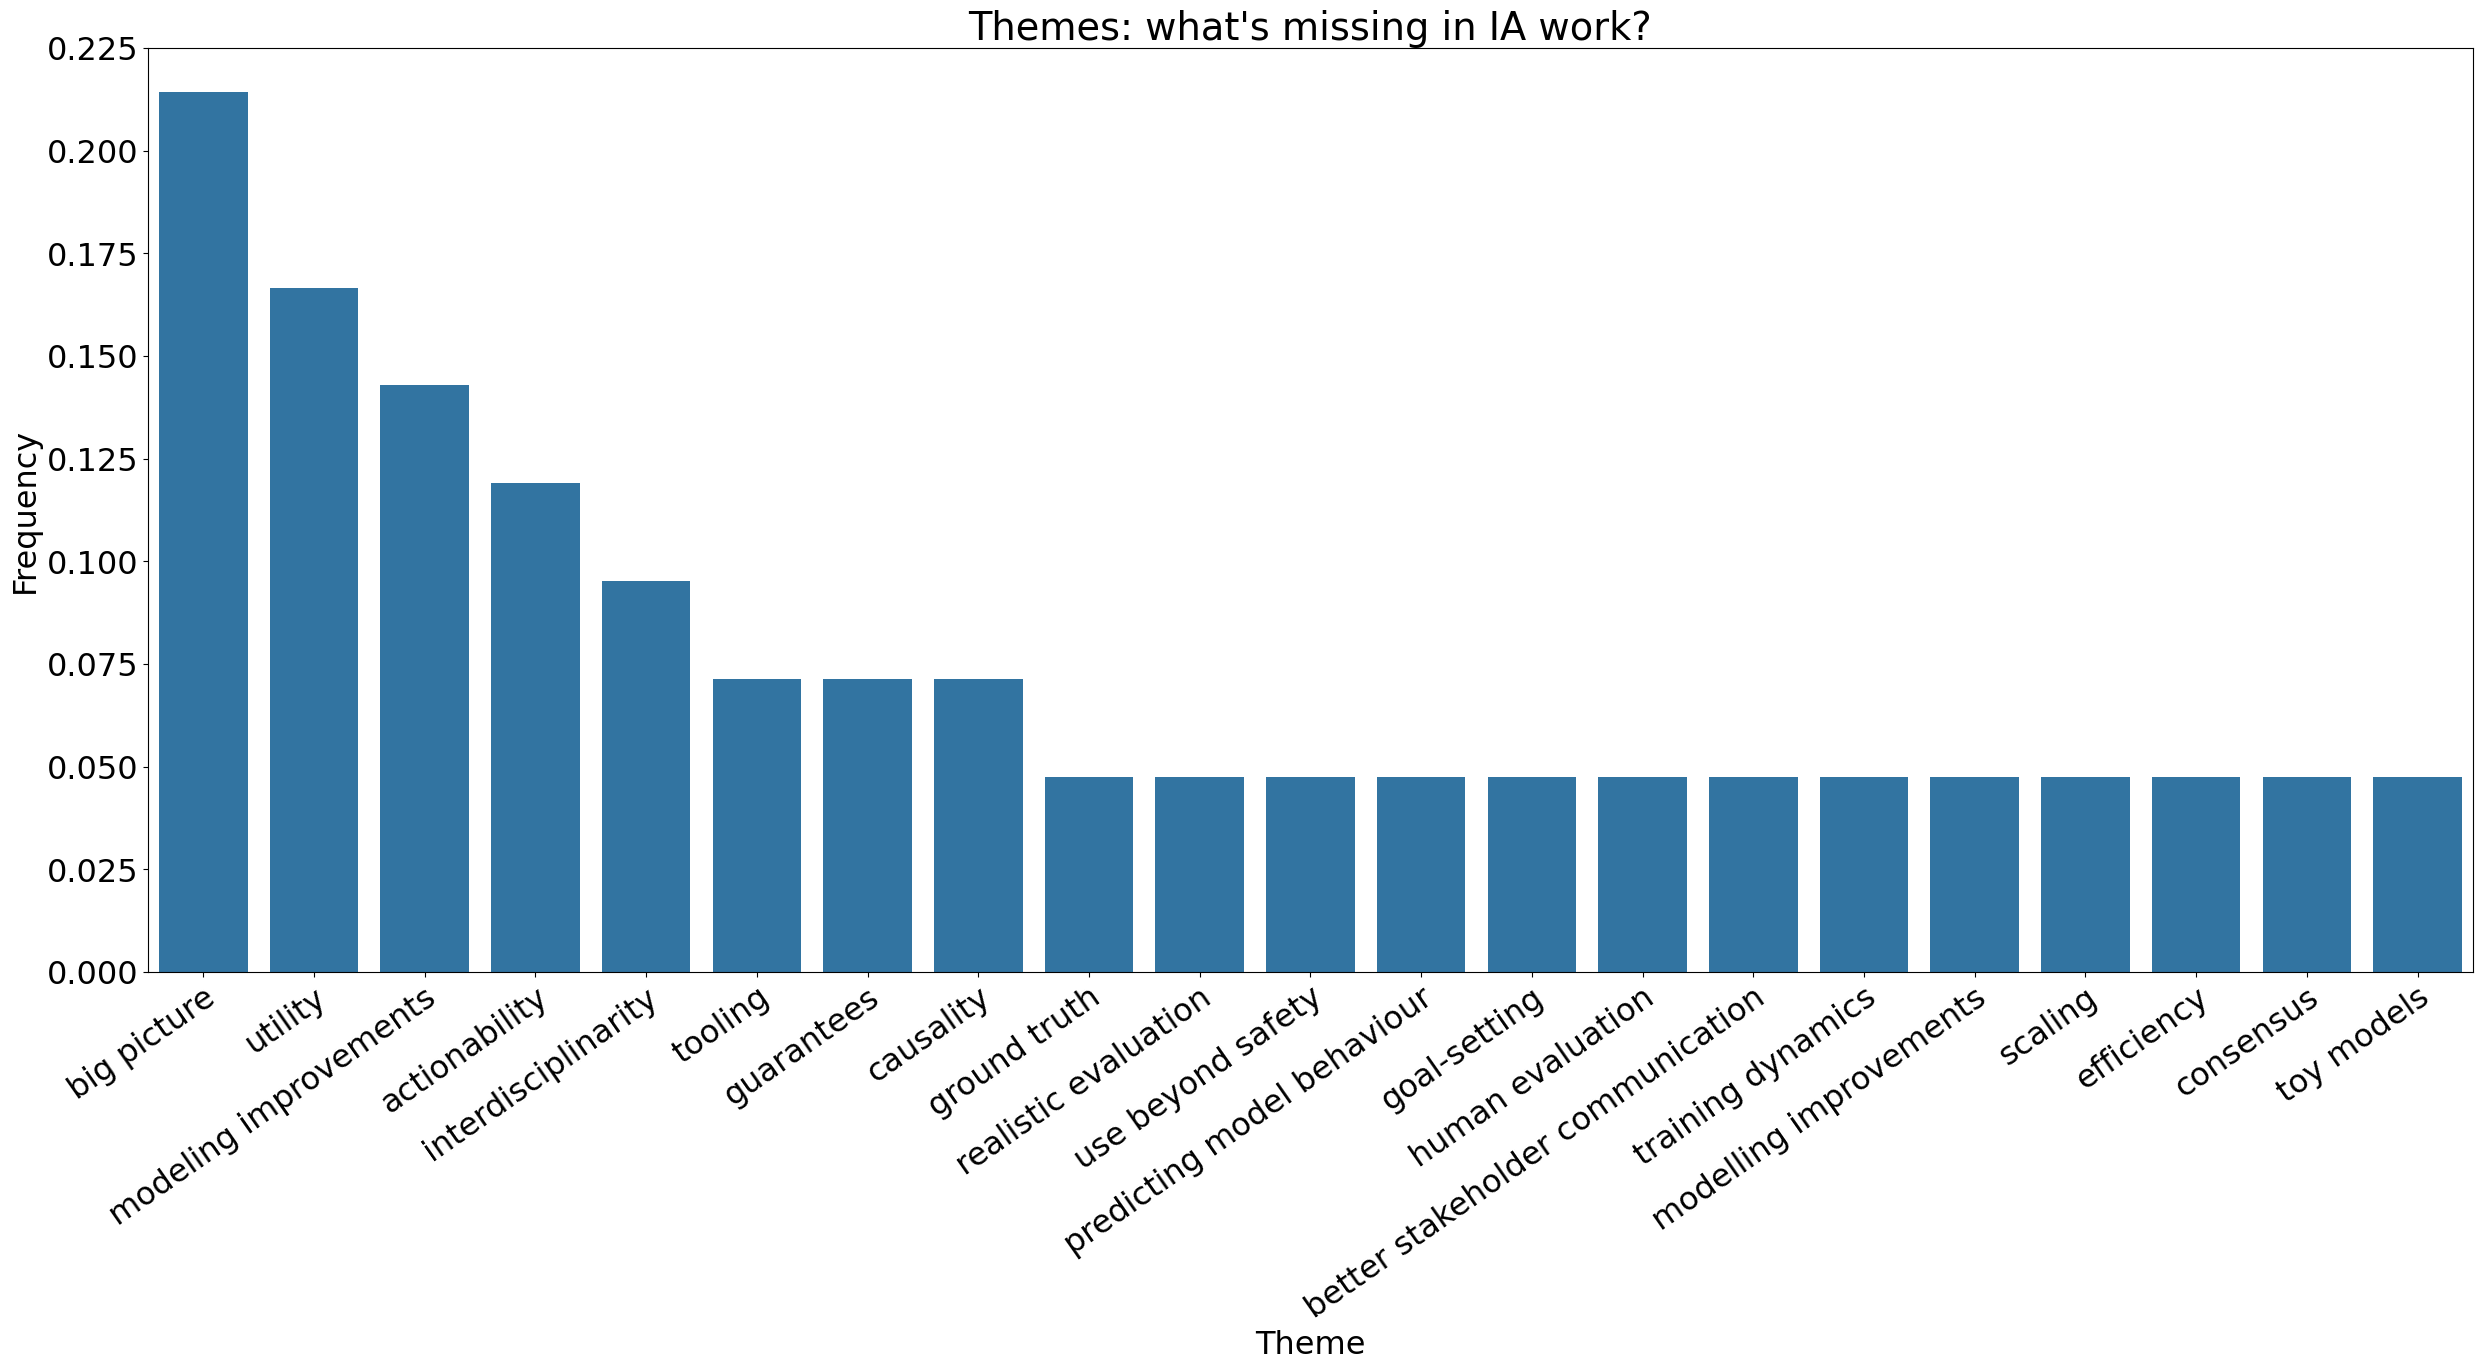

In [42]:
sorted_df = get_sorted_themes_df(whats_missing_df, survey_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 1]
sorted_df[1] = sorted_df[1]/len(whats_missing_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: what's missing in IA work?")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

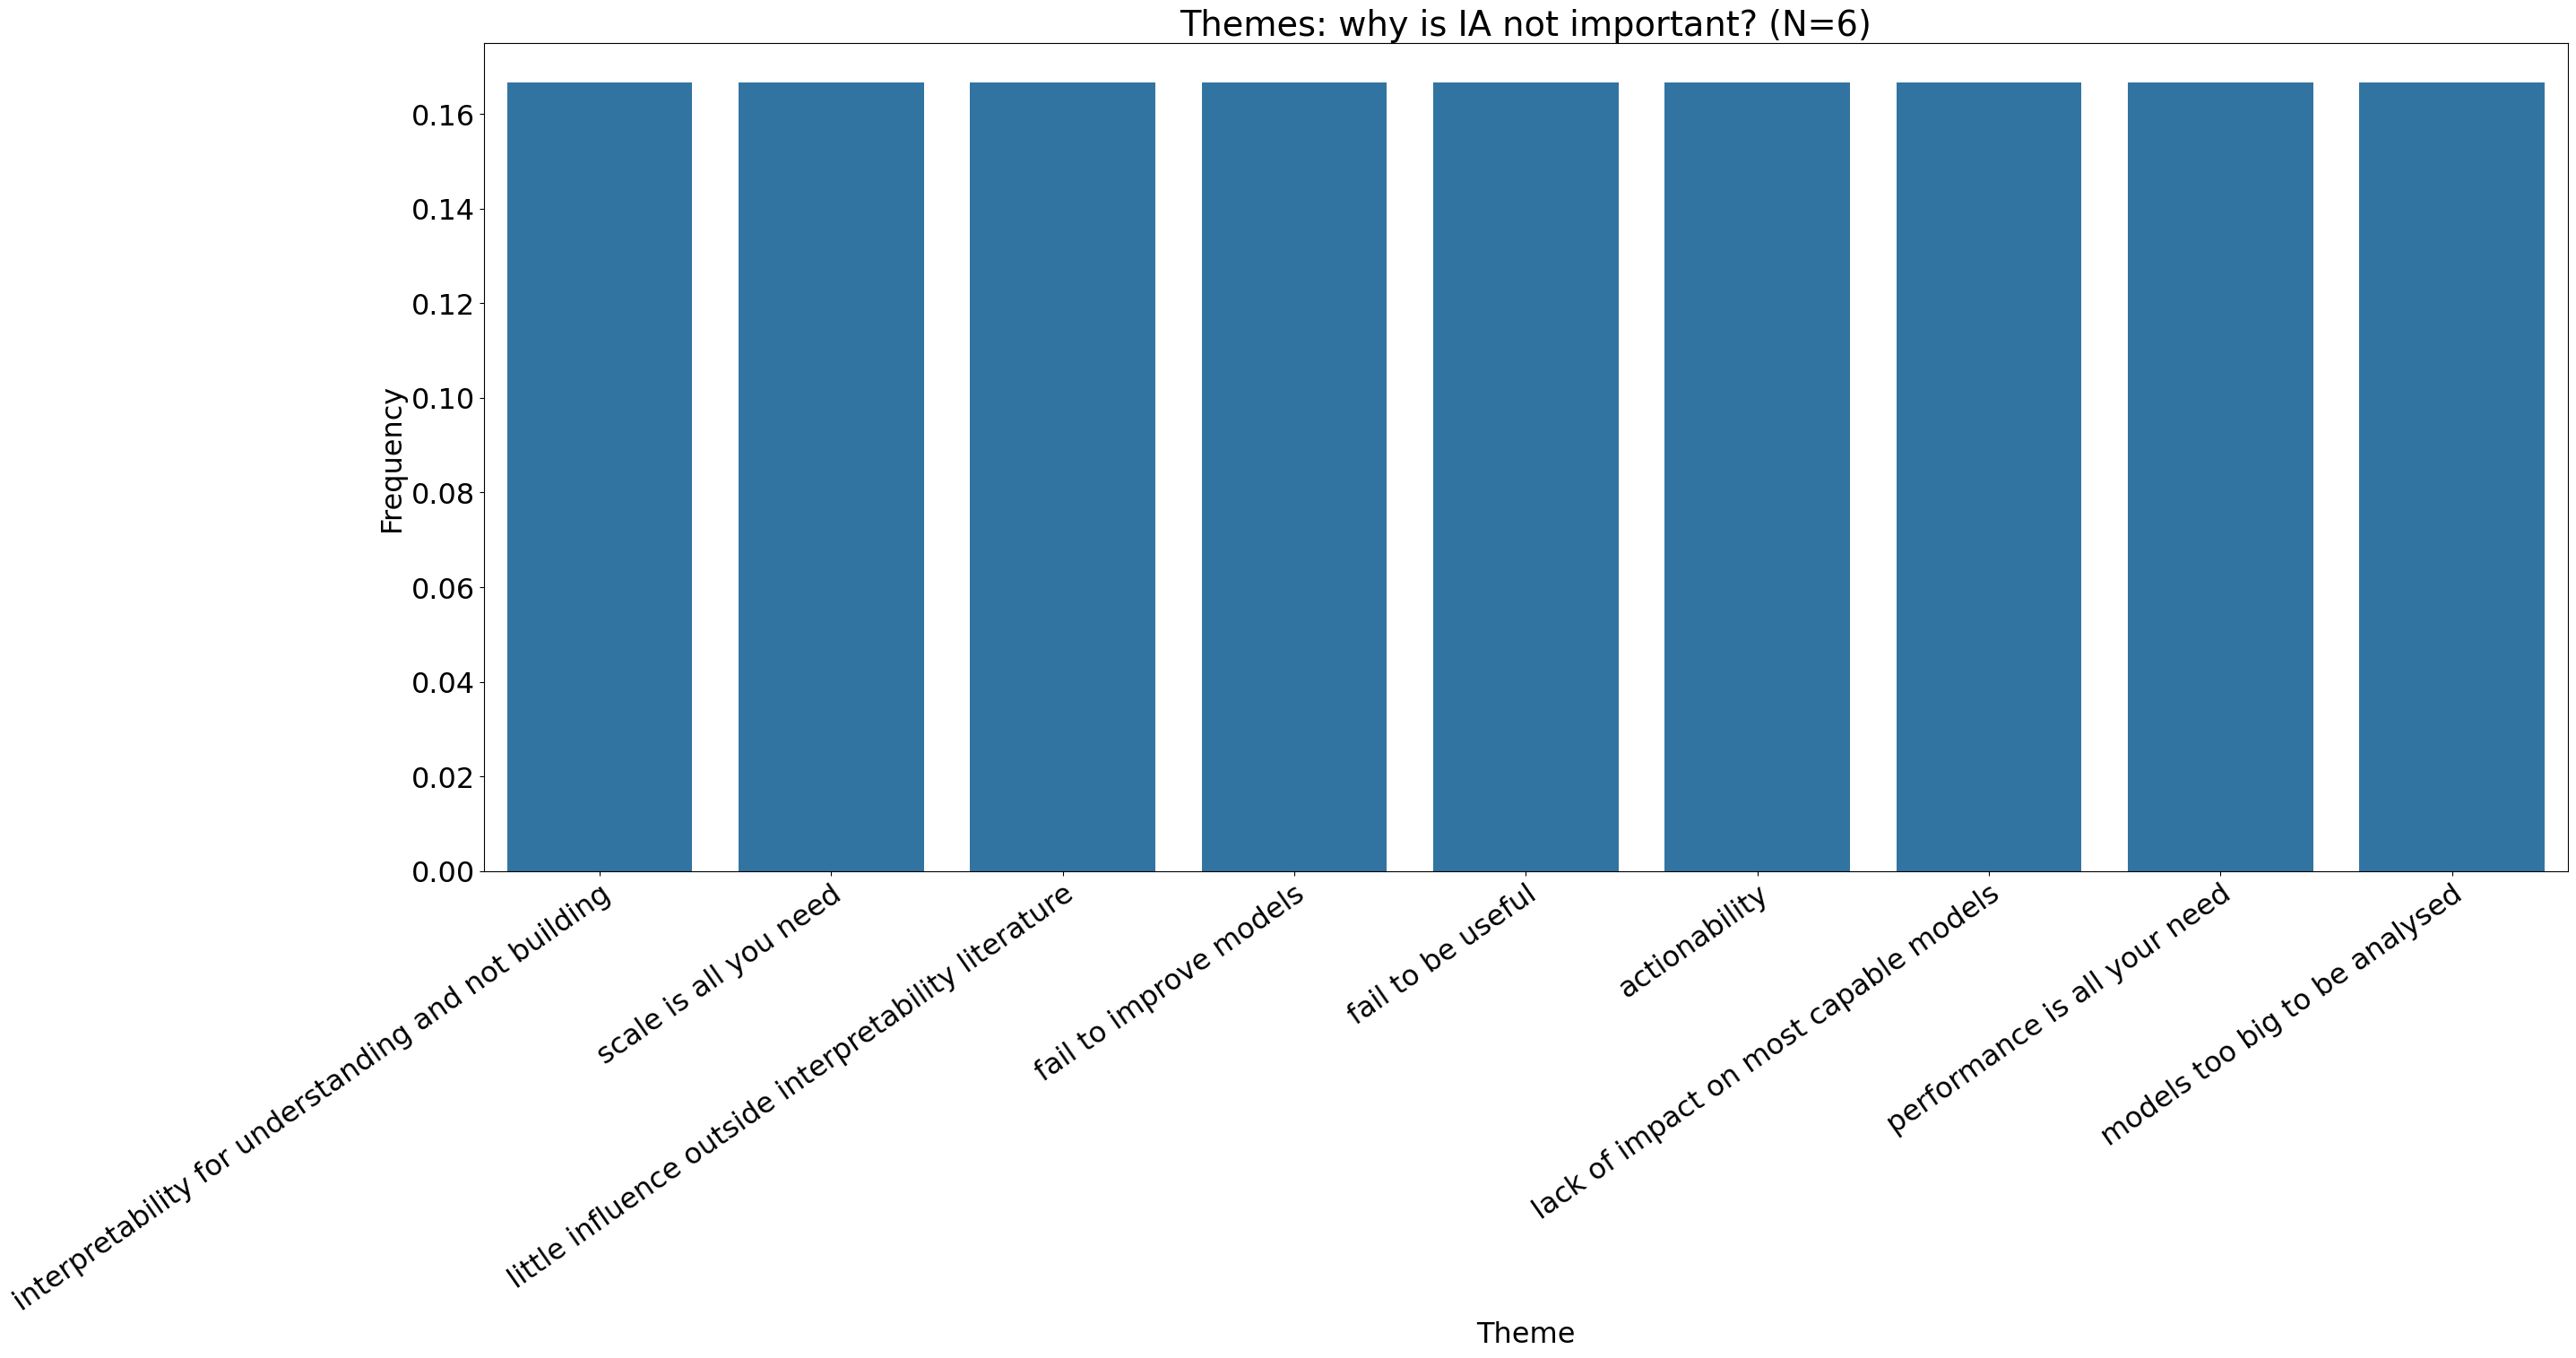

In [43]:
sorted_df = get_sorted_themes_df(why_not_important_df, survey_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 0]
sorted_df[1] = sorted_df[1]/len(why_not_important_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: why is IA not important? (N=6)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

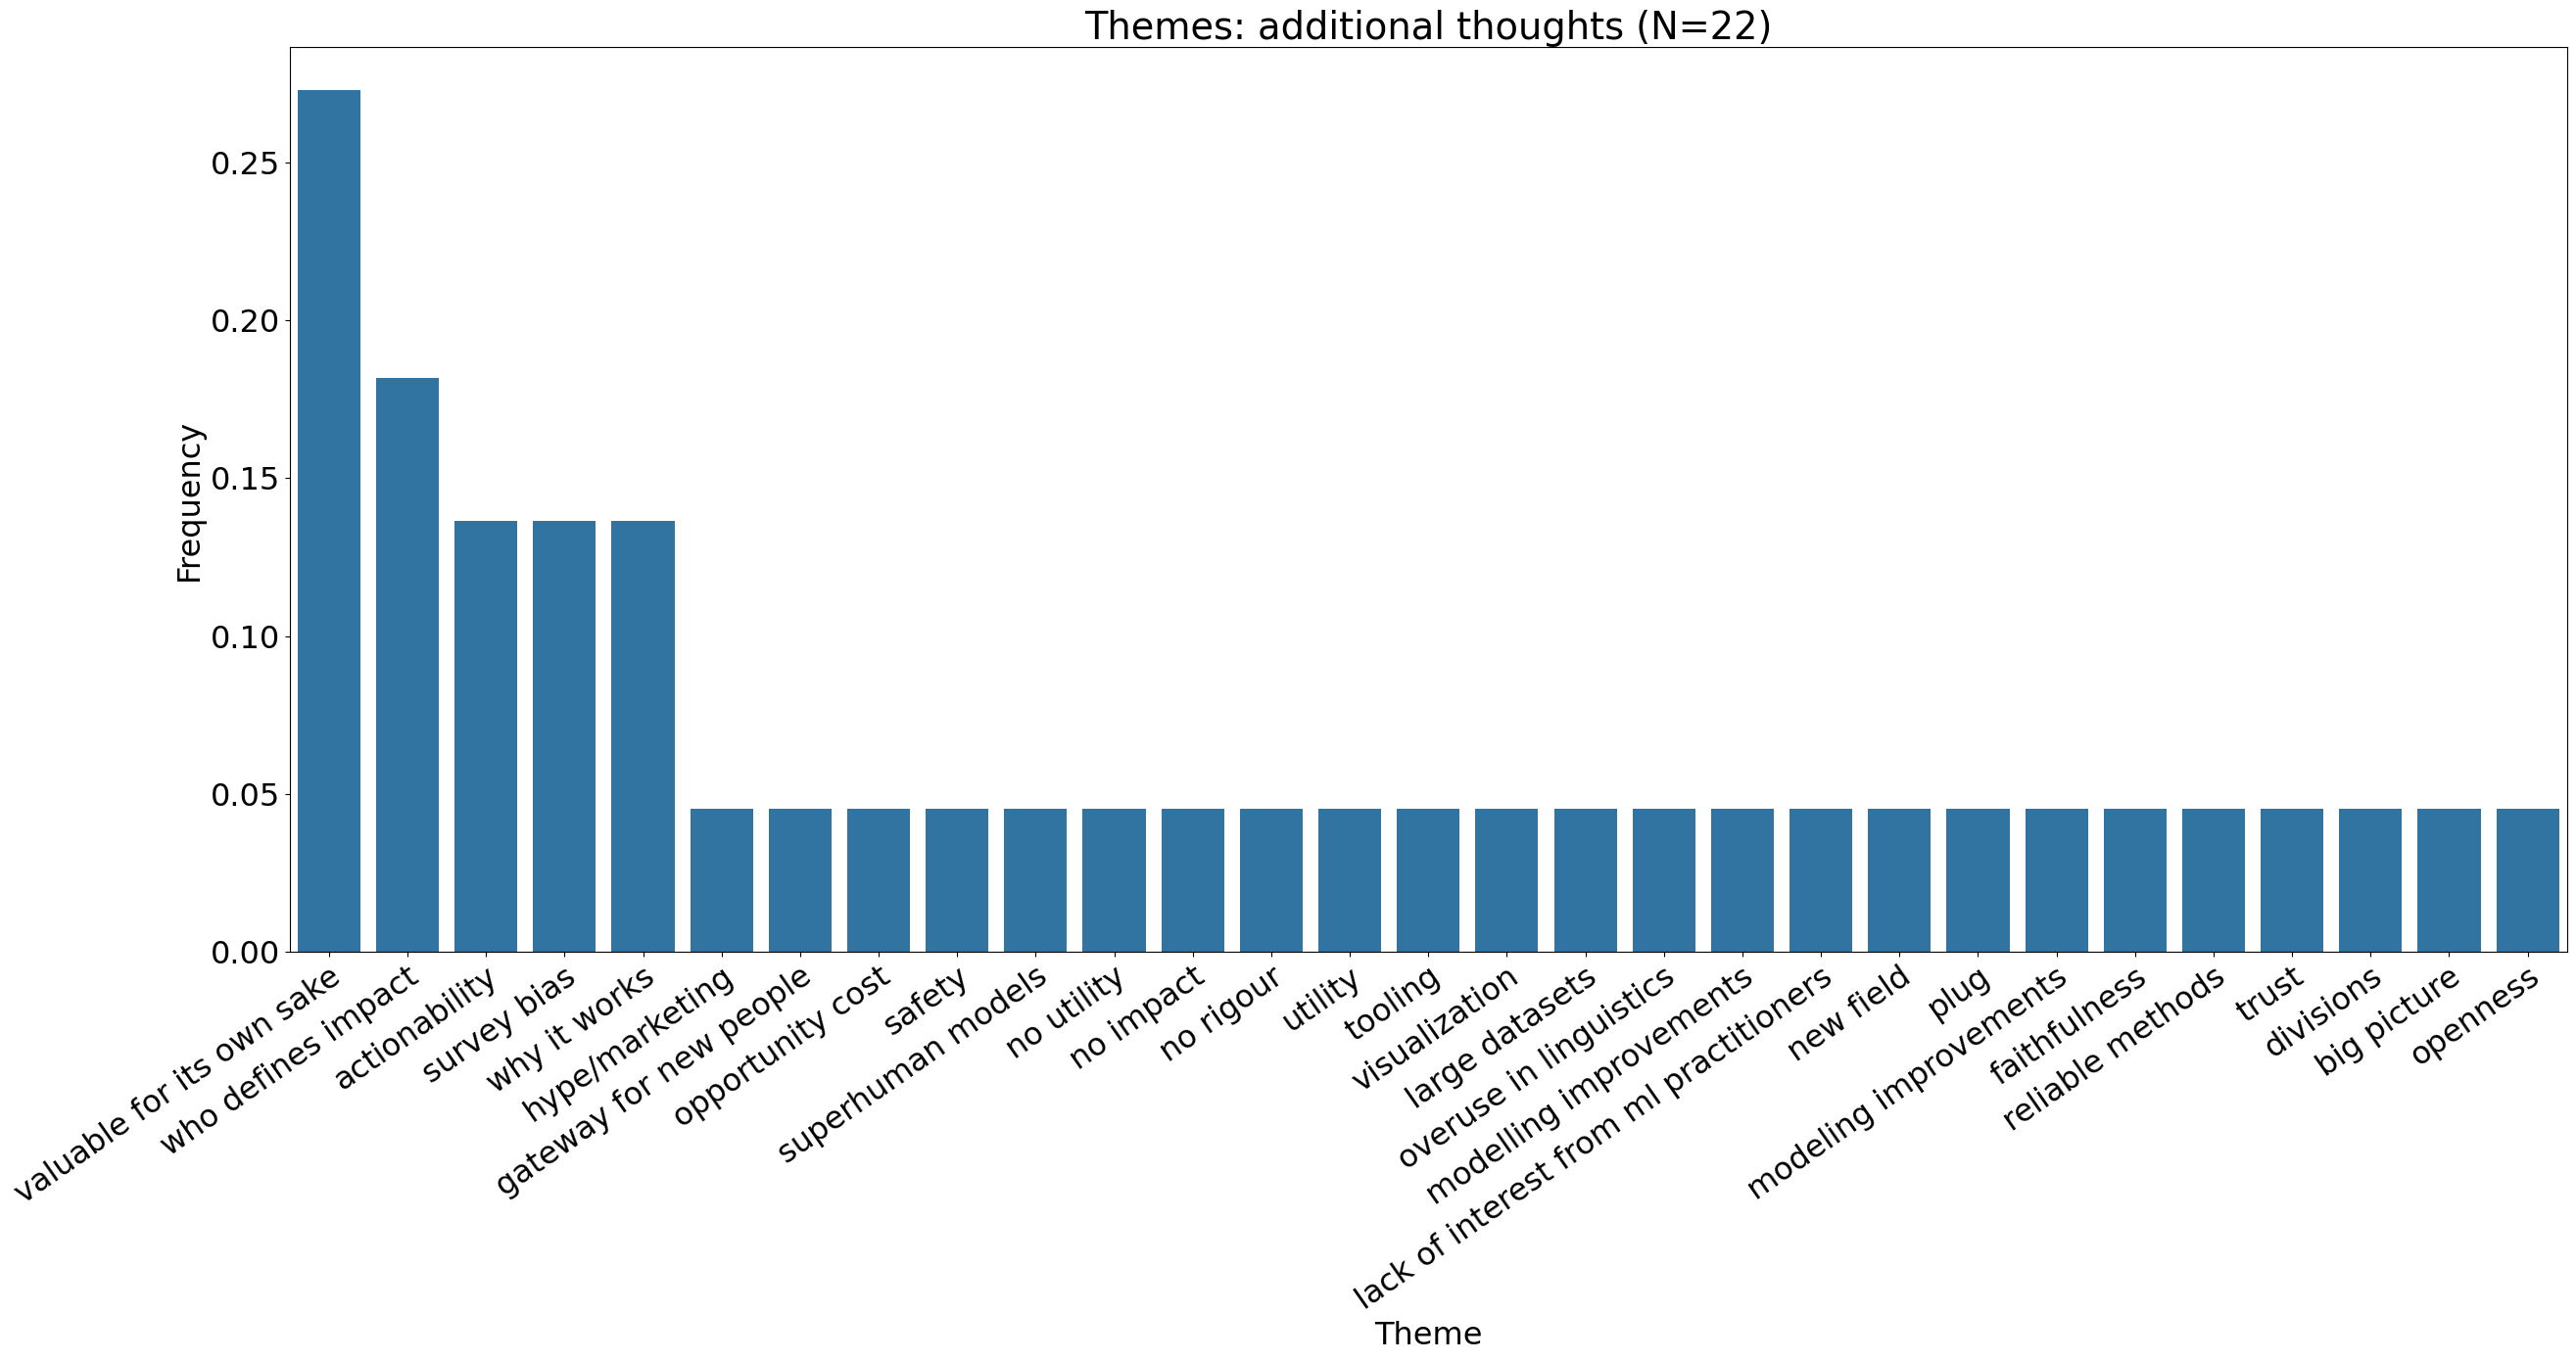

In [44]:
sorted_df = get_sorted_themes_df(additional_thoughts_df, survey_normalizing_dict)
sorted_df = sorted_df[sorted_df[1] > 0]
sorted_df[1] = sorted_df[1]/len(additional_thoughts_df)
plt.figure(figsize=(30,12))
ax = sns.barplot(sorted_df, x=0, y=1)
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.title("Themes: additional thoughts (N=22)")
plt.xlabel('Theme')
plt.ylabel('Frequency')
plt.show()

## Summary statistics and inter-coder reliability

In [45]:
def agreement_scores(df, col_a, col_b, normalizing_dict):
    # number of themes per comment
    num_themes_by_comment = []
    all_themes_ever = []
    identical_codes = 0
    total_codes = 0
    for i, row in df.iterrows():
        vagrant_themes, marius_themes = [], []
        if type(row[col_a]) != float:
            vagrant_themes += [normalize(t.strip().lower(), normalizing_dict) for t in row[col_a].split(',')]
        if type(row[col_b]) != float:
            marius_themes += [normalize(t.strip().lower(), normalizing_dict) for t in row[col_b].split(',')]
        all_themes = list(set(vagrant_themes).union(set(marius_themes)))
        all_themes_ever += all_themes
        num_themes_by_comment.append(len(all_themes))
        for theme in all_themes:
            if theme in vagrant_themes and theme in marius_themes:
                identical_codes += 1
            total_codes += 1
    print('number of themes per comment', sum(num_themes_by_comment)/len(num_themes_by_comment))
    print('number of unique themes', len(set(all_themes_ever)))
    print('percentage agreement', identical_codes / total_codes * 100)

In [46]:
agreement_scores(top50_interp_df, 'vagrant_themes', 'marius_themes', papers_normalizing_dict)

number of themes per comment 5.38
number of unique themes 115
percentage agreement 97.02602230483272


In [47]:
agreement_scores(top50_other_df, 'vagrant_themes', 'marius_themes', papers_normalizing_dict)

number of themes per comment 4.46
number of unique themes 99
percentage agreement 96.41255605381166


In [48]:
agreement_scores(survey_interp_df, 'vagrant_themes', 'marius_themes', papers_normalizing_dict)

number of themes per comment 4.275862068965517
number of unique themes 59
percentage agreement 100.0


In [49]:
agreement_scores(citations_to_top50_interp_df, 'vagrant_themes', 'marius_themes', papers_normalizing_dict)

number of themes per comment 4.899122807017544
number of unique themes 327
percentage agreement 97.49328558639212


In [50]:
agreement_scores(whats_missing_df, 'vagrant_themes', 'marius_themes', survey_normalizing_dict)

number of themes per comment 2.119047619047619
number of unique themes 44
percentage agreement 91.01123595505618


In [51]:
agreement_scores(why_not_important_df, 'vagrant_themes', 'marius_themes', survey_normalizing_dict)

number of themes per comment 1.5
number of unique themes 9
percentage agreement 100.0


In [52]:
agreement_scores(additional_thoughts_df, 'vagrant_themes', 'marius_themes', survey_normalizing_dict)

number of themes per comment 1.9545454545454546
number of unique themes 29
percentage agreement 100.0
